# Airbnb - Mexico City

## Imports

Conectamos con Google Drive, donde se encuentran los arhcivos de los mapas para realizar los graficos de la CDMX.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cargamos las librerias que se ocupan para el desarrollo del proyecto.

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, \
    classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import GaussianNB

Configuracion de visualizaciones de las salidas de celdas.

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
sns.set_style('whitegrid')
odx = pd.IndexSlice

In [6]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Get and load data

Para consultar los datos en linea, el archivo con los datos se puede descargar manualmente. Pero se desarrolla el siguiente script para extraer el archivo y transformalo en el formato que necesitamos.

In [7]:
def read_url(link):
    """ Creates a pandas DataFrame from online data
    - Parameters:
        - link: link to the zipped data
    - Returns:
        - df: pandas DataFrame
    """

    import io
    import requests
    import pandas as pd

    # Define URL and extract information
    response = requests.get(link)
    content = response.content
    # Convert into a Pandas DataFrame
    df = pd.read_csv(io.BytesIO(content), sep=',', compression='gzip')

    return df

In [8]:
listings = read_url('https://data.insideairbnb.com/mexico/df/mexico-city/2025-03-19/data/listings.csv.gz')
listings.shape

(26067, 79)

## Exploratory Data Analysis

Configuramos los tipos de datos, algunas son observadas desde el primer head del conjunto de datos

In [9]:
# variable type date to pd.datetime format
listings['last_scraped'] = pd.to_datetime(listings['last_scraped'])
listings['host_since'] = pd.to_datetime(listings['host_since'])

# Setting numeric values that they are in text format, drop char like %, (,), $
listings['host_response_rate'] = listings['host_response_rate'].str.replace('%', '')
listings['host_response_rate'] = listings['host_response_rate'].astype(float)

listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.replace('%', '')
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].astype(float)

listings['price'] = listings['price'].str.replace('$', '')
listings['price'] = listings['price'].str.replace(',', '')
listings['price'] = listings['price'].astype(float)

# listings['maximum_nights_avg_ntm'] = listings['maximum_nights_avg_ntm'].str.replace(',','')
listings['maximum_nights_avg_ntm'] = listings['maximum_nights_avg_ntm'].astype(float)

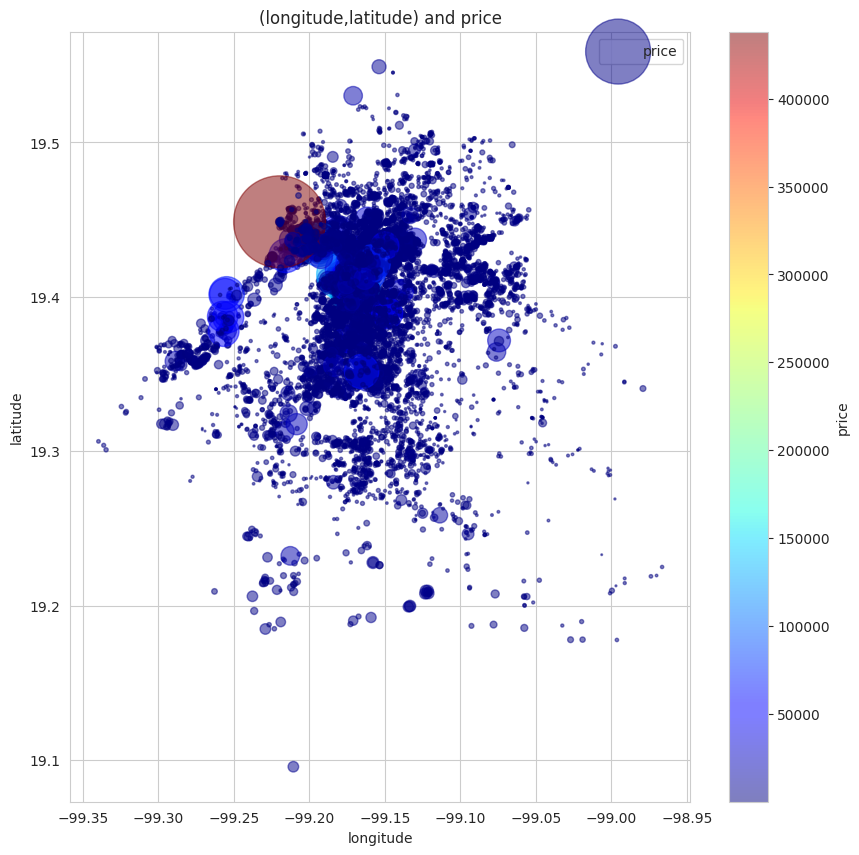

In [10]:
# show listings ubications and price
listings.plot(kind='scatter',
            x='longitude',
            y='latitude',
            alpha=0.5,
            s=listings['price']/100,
            label="price",
            figsize=(10, 10),
            c='price',
            cmap=plt.get_cmap('jet'),
            colorbar=True)
plt.title('(longitude,latitude) and price')
plt.legend()
plt.show()

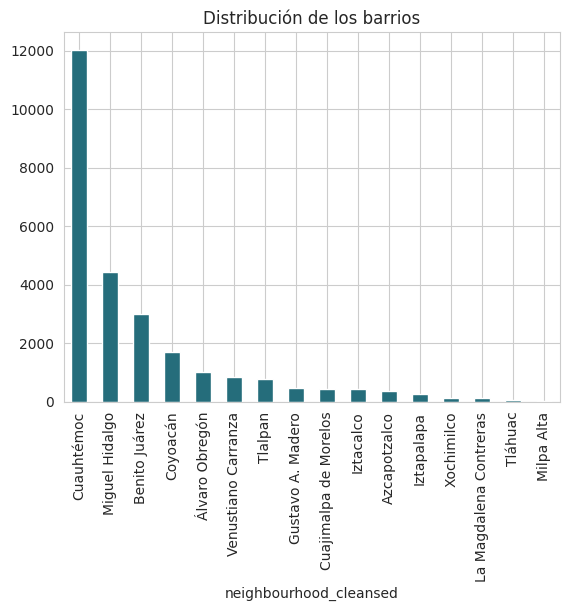

In [11]:
# count neighbourhood
listings['neighbourhood_cleansed'].value_counts().plot(kind='bar', color='#256D7B')
plt.title('Distribución de los barrios')
plt.show()

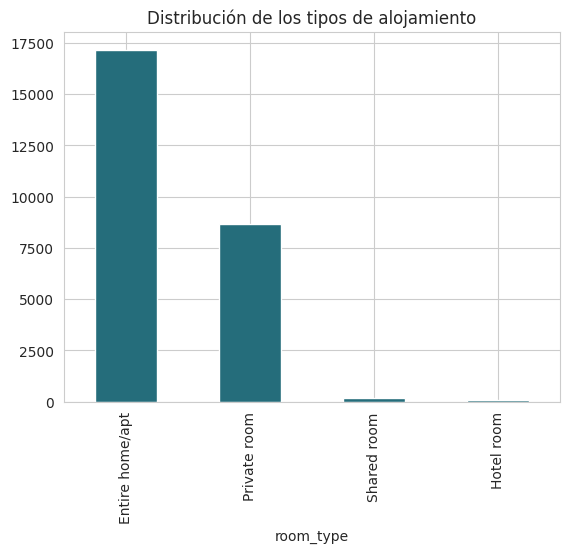

In [12]:
# show room_type value counts
listings['room_type'].value_counts().plot(kind='bar', color='#256D7B')
plt.title('Distribución de los tipos de alojamiento')
plt.show()

## Ingenieria de Variables

Funciones aplicadas al DataFrame

In [13]:
def host_in_location(str_location):
    """ Return 1 if the host_location in Mexico, else 0
    - Parameters:
        - str_location = data location
    - Output:
        - bin: int
    """
    str_loc = str(str_location).upper()
    str_mex = ['MEXICO', 'MÉXICO', 'CDMX', 'CIUDAD DE MEXICO',
               'DISTRITO FEDERAL', 'MX', 'MEX.', 'MEX']
    for loc in str_mex:
        if loc in str_loc:
            return 1

    return 0

def get_n_bedrooms(room_type, bedrooms, n_beds):
    # if is private, then is bedroom
    if 'Private' in room_type or 'Entire' in room_type:
        return 1
    # if is shared it
    if 'Shared' in room_type:
        return 0
    # If there are more beds than bedrooms, so it's a share room
    if n_beds > bedrooms:
        return 0
    # if there are more beds and it is hotel, so it's a shared room
    if n_beds > bedrooms or 'Hotel room' in room_type:
        return 0
    # it is a hotel's bedroom
    if n_beds <= bedrooms or 'Hotel room' in room_type:
        return 0

    return bedrooms

In [14]:
# column "host_verifications" contains a list with verifications, we separate each column into a different column
listings['host_verifications_email'] = listings['host_verifications'].map( lambda x: 1 if 'email' in str(x) else 0 )
listings['host_verifications_phone'] = listings['host_verifications'].map( lambda x: 1 if 'phone' in str(x) else 0 )
listings['host_verifications_workemail'] = listings['host_verifications'].map( lambda x: 1 if 'work_email' in str(x) else 0 )

# Compute number of host's verification
listings['host_verifications_num'] = listings['host_verifications_email']+listings['host_verifications_phone']+listings['host_verifications_phone']

# column 'amenities' contains a list, we get the amenities number that host provides
listings['len_amenities'] = listings['amenities'].map(lambda x: len(str(x).split(',')))

# Indicates wheter the owner (owner) is in Mexico or no, according the direction that it provides
listings['host_in_location'] = listings['host_location'].map(lambda x: host_in_location(x))

# We get the bedrooms number, it can have more than one bedroom, basing on bedroom type and beds number
listings['bedrooms_n'] = listings.apply( lambda x: get_n_bedrooms(x['room_type'], x['bedrooms'], x['beds']) , axis=1)

In [15]:
listings[listings['bedrooms'].isna()][['room_type','bedrooms','bedrooms_n']].sample(10)

room_type  bedrooms  bedrooms_n
13856     Private room       NaN           1
7055      Private room       NaN           1
23729      Shared room       NaN           0
10267     Private room       NaN           1
17481     Private room       NaN           1
150       Private room       NaN           1
796       Private room       NaN           1
4898      Private room       NaN           1
3819      Private room       NaN           1
10049  Entire home/apt       NaN           1

In [16]:
listings[listings['bedrooms_n'].isna()]

Empty DataFrame
Columns: [id, listing_url, scrape_id, last_scraped, source, name, description, neighborhood_overview, picture_url, host_id, host_url, host_name, host_since, host_location, host_about, host_response_time, host_response_rate, host_acceptance_rate, host_is_superhost, host_thumbnail_url, host_picture_url, host_neighbourhood, host_listings_count, host_total_listings_count, host_verifications, host_has_profile_pic, host_identity_verified, neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed, latitude, longitude, property_type, room_type, accommodates, bathrooms, bathrooms_text, bedrooms, beds, amenities, price, minimum_nights, maximum_nights, minimum_minimum_nights, maximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm, calendar_updated, has_availability, availability_30, availability_60, availability_90, availability_365, calendar_last_scraped, number_of_reviews, number_of_reviews_ltm, number_of_reviews_l30d, availability_eoy, number_of_reviews_ly, estimated_occupancy_l365d, estimated_revenue_l365d, first_review, last_review, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, license, instant_bookable, calculated_host_listings_count, calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms, calculated_host_listings_count_shared_rooms, reviews_per_month, host_verifications_email, host_verifications_phone, host_verifications_workemail, host_verifications_num, len_amenities, host_in_location, bedrooms_n]
Index: []

Limpieza del numero de camas, puede que sea un cuarto con varias camas.

In [17]:
def get_n_beds(room_type, beds):
    if float(beds) >= 0:
        return beds

    if room_type in ['Private room', 'Hotel room', 'Entire home/apt', 'Shared room']:
        return 1


In [18]:
listings['beds_n'] = listings.apply(lambda x: get_n_beds(x['room_type'], x['beds']), axis=1)

In [19]:
print(listings['beds_n'].isna().sum())

0


In [20]:
listings[listings['beds_n'].isna()]

Empty DataFrame
Columns: [id, listing_url, scrape_id, last_scraped, source, name, description, neighborhood_overview, picture_url, host_id, host_url, host_name, host_since, host_location, host_about, host_response_time, host_response_rate, host_acceptance_rate, host_is_superhost, host_thumbnail_url, host_picture_url, host_neighbourhood, host_listings_count, host_total_listings_count, host_verifications, host_has_profile_pic, host_identity_verified, neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed, latitude, longitude, property_type, room_type, accommodates, bathrooms, bathrooms_text, bedrooms, beds, amenities, price, minimum_nights, maximum_nights, minimum_minimum_nights, maximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm, calendar_updated, has_availability, availability_30, availability_60, availability_90, availability_365, calendar_last_scraped, number_of_reviews, number_of_reviews_ltm, number_of_reviews_l30d, availability_eoy, number_of_reviews_ly, estimated_occupancy_l365d, estimated_revenue_l365d, first_review, last_review, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, license, instant_bookable, calculated_host_listings_count, calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms, calculated_host_listings_count_shared_rooms, reviews_per_month, host_verifications_email, host_verifications_phone, host_verifications_workemail, host_verifications_num, len_amenities, host_in_location, bedrooms_n, beds_n]
Index: []

Limpieza de datos para los registros de numero de baños

In [21]:
def get_n_bathrooms(value_int, value_txt):

    # If there is not record in any columns, returns 0
    if value_int is np.nan and value_txt is np.nan:
        return 0

    r = None

    try:
        r = float(value_txt.split(' ')[0])
        if value_int == np.nan:
            r = value_int
    except:
        r=0

    if value_int > r:
        r = value_int

    return r

In [22]:
listings['bathrooms_num'] = listings.apply( lambda x: get_n_bathrooms(x['bathrooms'], x['bathrooms_text']), axis=1)

Identificar si el bano es compartido o no

In [23]:
listings[['bathrooms_num', 'bathrooms_text', 'bedrooms']]

bathrooms_num  bathrooms_text  bedrooms
0               1.00          1 bath      1.00
1               5.50       5.5 baths      5.00
2               1.00          1 bath      1.00
3               1.00          1 bath      2.00
4               1.00          1 bath      1.00
...              ...             ...       ...
26062           1.00   1 shared bath       NaN
26063           1.00  1 private bath      1.00
26064           1.00   1 shared bath      1.00
26065           1.00          1 bath      1.00
26066           2.00         2 baths      2.00

[26067 rows x 3 columns]

In [24]:
# This section is not used

#def is_bath_priv(n_bathrooms, n_bedrooms):
#    if n_bathrooms < n_bedrooms:
#        return False

# Normalized space for longitude and latitude
#lat, lon = listings['latitude'], listings['longitude']
#listings['geo_x'] = np.multiply(np.cos(lat), np.cos(lon))
#listings['geo_y'] = np.multiply(np.cos(lat), np.sin(lon))
#listings['geo_z'] = np.sin(lat)
#listings = listings.drop(['latitude', 'longitude'], axis=1)

### Identificacion de variables

In [25]:
# sampling unit
um = ['id']

# target variable (contionous)
var_obj_num = ['price']

# tagrte variable (discreet) - classification
var_obj_cat = ['instant_bookable']

# categorical variables
var_disc = ['host_name', 'host_response_time', 'host_is_superhost',
            'host_has_profile_pic',
            'host_identity_verified',  'neighbourhood_cleansed', 'property_type',
            'room_type', 'has_availability', 'host_verifications_email',
            'host_verifications_phone', 'host_verifications_workemail',
            'host_in_location' ]

# continous variable
var_cont = ['host_response_rate', 'host_acceptance_rate', 'host_listings_count',
            'host_total_listings_count',
            'latitude', 'longitude',
            #'geo_x', 'geo_y', 'geo_z',
            'accommodates',
            'bedrooms_n', 'beds_n', 'minimum_nights', 'maximum_nights',
            'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
            'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
            'availability_30', 'availability_60', 'availability_90', 'availability_365',
            'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
            'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d',
            'estimated_revenue_l365d', 'review_scores_rating', 'review_scores_accuracy',
            'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
            'review_scores_location', 'review_scores_value', 'calculated_host_listings_count',
            'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
            'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'len_amenities',
            'host_verifications_num', 'bathrooms_num' ]

# date variables
var_date =['host_since', 'calendar_last_scraped', 'first_review', 'last_review', ]

# text variables
var_text = ['name', 'neighborhood_overview', 'description', 'picture_url', 'host_url',
            'host_about', 'host_thumbnail_url', 'host_picture_url', 'amenities']

# variables no used
var_drop = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'host_id',
            'neighbourhood', 'calendar_updated', 'neighbourhood_group_cleansed', 'license',
            'host_verifications', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'host_location',
            'host_neighbourhood']

In [26]:
print( "len (lista de variables): ", len( um + var_obj_num + var_obj_cat + var_disc + var_cont + var_date + var_text + var_drop ))
print( "len (dataframe):  ", listings.shape )

len (lista de variables):  88
len (dataframe):   (26067, 88)


#### Variables continuas

In [27]:
listings[ var_cont ].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26067 entries, 0 to 26066
Data columns (total 43 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_response_rate                            22563 non-null  float64
 1   host_acceptance_rate                          23328 non-null  float64
 2   host_listings_count                           26062 non-null  float64
 3   host_total_listings_count                     26062 non-null  float64
 4   latitude                                      26067 non-null  float64
 5   longitude                                     26067 non-null  float64
 6   accommodates                                  26067 non-null  int64  
 7   bedrooms_n                                    26067 non-null  int64  
 8   beds_n                                        26067 non-null  float64
 9   minimum_nights                                26067 non-null 

In [28]:
# show continous variables descriptions
listings[ var_cont ].describe( percentiles=[.01, .1, .25, .5, .75, .99], include='all').T

count      mean         std  \
host_response_rate                           22563.00     93.88       19.94   
host_acceptance_rate                         23328.00     88.88       24.65   
host_listings_count                          26062.00     25.90       86.77   
host_total_listings_count                    26062.00     35.07      123.98   
latitude                                     26067.00     19.41        0.04   
longitude                                    26067.00    -99.17        0.03   
accommodates                                 26067.00      3.35        2.36   
bedrooms_n                                   26067.00      0.99        0.10   
beds_n                                       26067.00      1.81        1.65   
minimum_nights                               26067.00      4.79       25.09   
maximum_nights                               26067.00    497.85      409.42   
minimum_minimum_nights                       26067.00      4.33       24.44   
maximum_minimum_nights                       26067.00      4.86       24.86   
minimum_maximum_nights                       26067.00  83078.23 13300997.11   
maximum_maximum_nights                       26067.00  83105.27 13300996.94   
minimum_nights_avg_ntm                       26067.00      4.55       24.54   
maximum_nights_avg_ntm                       26067.00  83091.16 13300997.03   
availability_30                              26067.00     12.81       10.62   
availability_60                              26067.00     32.65       21.20   
availability_90                              26067.00     54.66       31.57   
availability_365                             26067.00    218.32      130.07   
number_of_reviews                            26067.00     50.48       79.87   
number_of_reviews_ltm                        26067.00     15.17       22.01   
number_of_reviews_l30d                       26067.00      1.22        1.92   
availability_eoy                             26067.00    178.37      102.10   
number_of_reviews_ly                         26067.00     14.51       21.68   
estimated_occupancy_l365d                    26067.00     82.53       89.76   
estimated_revenue_l365d                      22068.00 137057.08   281565.33   
review_scores_rating                         22806.00      4.75        0.38   
review_scores_accuracy                       22805.00      4.78        0.37   
review_scores_cleanliness                    22805.00      4.75        0.38   
review_scores_checkin                        22805.00      4.84        0.33   
review_scores_communication                  22805.00      4.82        0.36   
review_scores_location                       22805.00      4.84        0.30   
review_scores_value                          22805.00      4.71        0.39   
calculated_host_listings_count               26067.00     15.49       36.23   
calculated_host_listings_count_entire_homes  26067.00     12.62       35.80   
calculated_host_listings_count_private_rooms 26067.00      2.69        7.34   
calculated_host_listings_count_shared_rooms  26067.00      0.14        1.57   
reviews_per_month                            22806.00      1.80        2.03   
len_amenities                                26067.00     32.21       16.28   
host_verifications_num                       26067.00      2.90        0.32   
bathrooms_num                                26067.00      1.46        1.10   

                                                min     1%    10%     25%  \
host_response_rate                             0.00   0.00  89.00  100.00   
host_acceptance_rate                           0.00   0.00  60.00   94.00   
host_listings_count                            1.00   1.00   1.00    1.00   
host_total_listings_count                      1.00   1.00   1.00    2.00   
latitude                                      19.10  19.27  19.35   19.39   
longitude                                    -99.34 -99.28 -99.20  -99.18   
accommodates                    

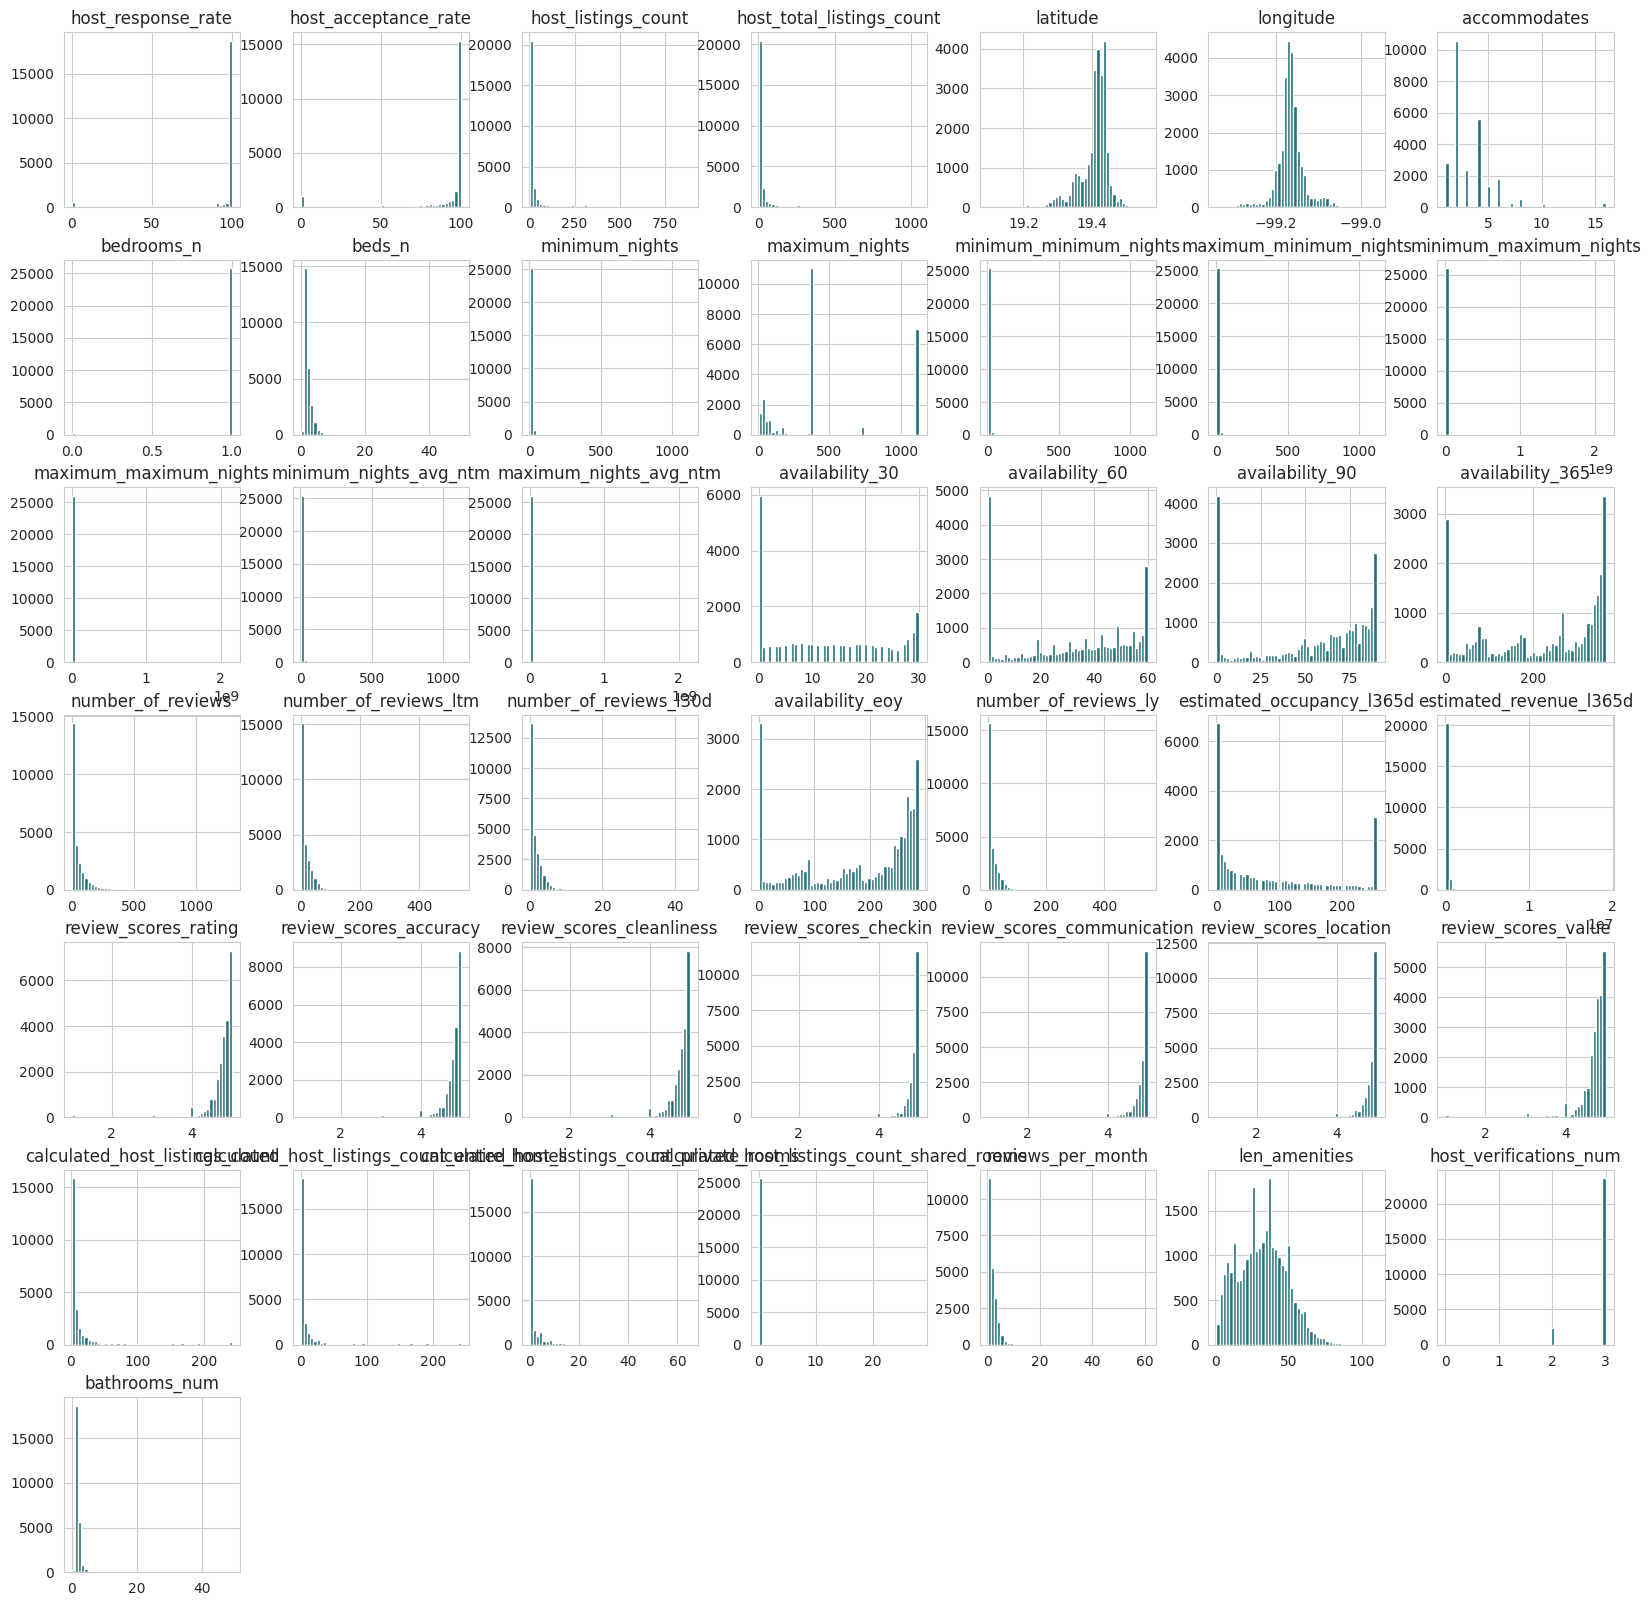

In [29]:
# histogram of continuous variables
listings[ var_cont ].hist(bins=50, figsize=(20,20), color='#256D7B')
plt.show()

#### Valores ausentes

In [30]:
# only columns with missing values
aux = pd.DataFrame(listings[var_cont].isna().sum())
aux = aux.sort_values(by=0).reset_index()
aux[aux[0] > 0]

index     0
30          host_listings_count     5
31    host_total_listings_count     5
32         host_acceptance_rate  2739
33         review_scores_rating  3261
34            reviews_per_month  3261
35       review_scores_location  3262
36    review_scores_cleanliness  3262
37  review_scores_communication  3262
38       review_scores_accuracy  3262
39        review_scores_checkin  3262
40          review_scores_value  3262
41           host_response_rate  3504
42      estimated_revenue_l365d  3999

In [31]:
# imputation of values with the median
listings['host_listings_count'] = listings['host_listings_count'].fillna(0)
listings['host_total_listings_count'] = listings['host_total_listings_count'].fillna(0)
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].fillna(listings['host_acceptance_rate'].median())
listings['review_scores_rating'] = listings['review_scores_rating'].fillna(int(listings['review_scores_rating'].mode()))
listings['reviews_per_month'] = listings['reviews_per_month'].fillna(0)
listings['review_scores_accuracy'] = listings['review_scores_accuracy'].fillna(int(listings['review_scores_accuracy'].median()))
listings['review_scores_location'] = listings['review_scores_location'].fillna(int(listings['review_scores_location'].median()))
listings['review_scores_communication'] = listings['review_scores_communication'].fillna(int(listings['review_scores_communication'].median()))
listings['review_scores_checkin'] = listings['review_scores_checkin'].fillna(int(listings['review_scores_checkin'].median()))
listings['review_scores_cleanliness'] = listings['review_scores_cleanliness'].fillna(int(listings['review_scores_cleanliness'].median()))
listings['review_scores_value'] = listings['review_scores_value'].fillna(int(listings['review_scores_value'].median()))
listings['host_response_rate'] = listings['host_response_rate'].fillna(int(listings['host_response_rate'].median()))
listings['estimated_revenue_l365d'] = listings['estimated_revenue_l365d'].fillna(listings['estimated_revenue_l365d'].mean())

In [32]:
listings[var_cont].isna().sum()

host_response_rate                              0
host_acceptance_rate                            0
host_listings_count                             0
host_total_listings_count                       0
latitude                                        0
longitude                                       0
accommodates                                    0
bedrooms_n                                      0
beds_n                                          0
minimum_nights                                  0
maximum_nights                                  0
minimum_minimum_nights                          0
maximum_minimum_nights                          0
minimum_maximum_nights                          0
maximum_maximum_nights                          0
minimum_nights_avg_ntm                          0
maximum_nights_avg_ntm                          0
availability_30                                 0
availability_60                                 0
availability_90                                 0
availability_365                                0
number_of_reviews                               0
number_of_reviews_ltm                           0
number_of_reviews_l30d                          0
availability_eoy                                0
number_of_reviews_ly                            0
estimated_occupancy_l365d                       0
estimated_revenue_l365d                         0
review_scores_rating                            0
review_scores_accuracy                          0
review_scores_cleanliness                       0
review_scores_checkin                           0
review_scores_communication                     0
review_scores_location                          0
review_scores_value                             0
calculated_host_listings_count                  0
calculated_host_listings_count_entire_homes     0
calculated_host_listings_count_private_rooms    0
calculated_host_listings_count_shared_rooms     0
reviews_per_month                               0
len_amenities                                   0
host_verifications_num                          0
bathrooms_num                                   0
dtype: int64

minimum_nights

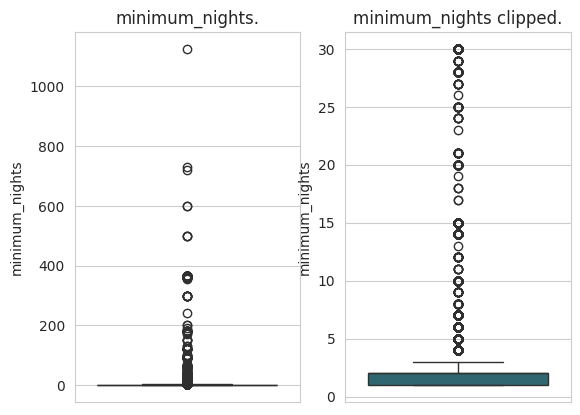

In [33]:
# Plot 1: boxplot before
plt.subplot(1,2,1)
sns.boxplot(listings[ 'minimum_nights' ], color='#256D7B')
plt.title(f"minimum_nights.")

# Plot 2: boxplot after
plt.subplot(1,2,2)
sns.boxplot(listings[ 'minimum_nights' ].clip(upper=listings['minimum_nights'].quantile(.98)), color='#256D7B')
plt.title(f"minimum_nights clipped.")

plt.show()


In [34]:
print(listings.shape)
listings = listings[ ~(listings['minimum_nights'] > listings['minimum_nights'].quantile(.98)) ]
print(listings.shape)

(26067, 88)
(25788, 88)


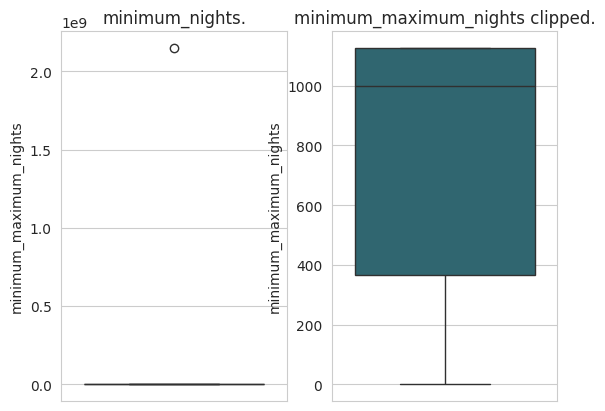

In [35]:
# Plot 1: boxplot before
plt.subplot(1,2,1)
sns.boxplot(listings[ 'minimum_maximum_nights' ], color='#256D7B')
plt.title(f"minimum_nights.")

# Plot 2: boxplot after
plt.subplot(1,2,2)
sns.boxplot(listings[ 'minimum_maximum_nights' ].clip(upper=listings['minimum_maximum_nights'].quantile(.99)), color='#256D7B')
plt.title(f"minimum_maximum_nights clipped.")

plt.show()

In [36]:
listings = listings[ ~(listings['minimum_maximum_nights'] > listings['minimum_maximum_nights'].quantile(.999)) ]
listings.shape

(25786, 88)

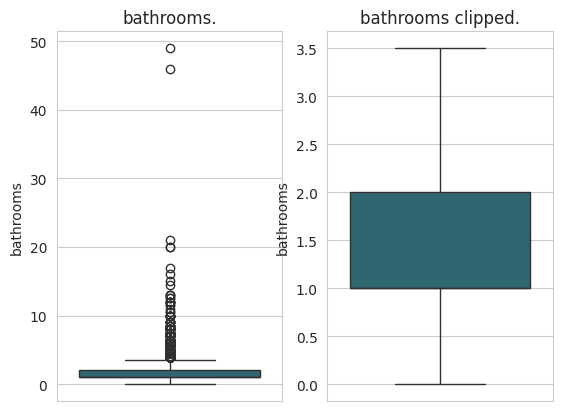

In [37]:
# Plot 1: boxplot before
plt.subplot(1,2,1)
sns.boxplot(listings[ 'bathrooms' ], color='#256D7B')
plt.title(f"bathrooms.")

# Plot 2: boxplot after
plt.subplot(1,2,2)
sns.boxplot(listings[ 'bathrooms' ].clip(upper=listings['bathrooms'].quantile(.97)), color='#256D7B')
plt.title(f"bathrooms clipped.")

plt.show()

In [38]:
listings = listings[ ~(listings['bathrooms'] > listings['bathrooms'].quantile(.97)) ]
listings.shape

(25218, 88)

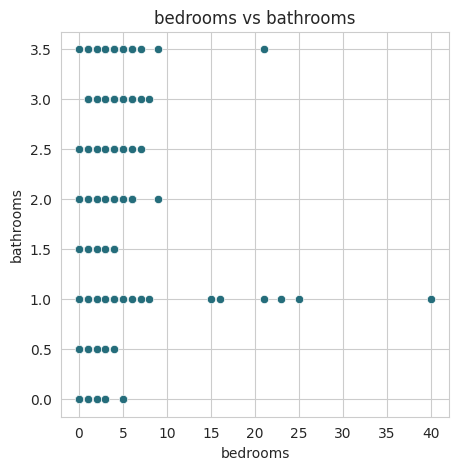

In [39]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='bedrooms', y='bathrooms', data=listings, color='#256D7B')
plt.title('bedrooms vs bathrooms')
plt.show()

In [40]:
listings[ var_cont ].describe( percentiles=[.01, .1, .25, .5, .75, .99], include='all')

host_response_rate  host_acceptance_rate  host_listings_count  \
count            25218.00              25218.00             25218.00   
mean                94.73                 90.19                25.75   
std                 18.60                 23.20                87.13   
min                  0.00                  0.00                 0.00   
1%                   0.00                  0.00                 1.00   
10%                 90.00                 68.00                 1.00   
25%                100.00                 96.00                 1.00   
50%                100.00                 99.00                 4.00   
75%                100.00                100.00                14.00   
99%                100.00                100.00               442.00   
max                100.00                100.00               886.00   

       host_total_listings_count  latitude  longitude  accommodates  \
count                   25218.00  25218.00   25218.00      25218.00   
mean                       34.80     19.41     -99.17          3.22   
std                       123.83      0.04       0.03          2.05   
min                         0.00     19.18     -99.34          1.00   
1%                          1.00     19.27     -99.28          1.00   
10%                         1.00     19.35     -99.20          1.00   
25%                         2.00     19.39     -99.18          2.00   
50%                         5.00     19.42     -99.17          2.00   
75%                        17.00     19.43     -99.15          4.00   
99%                       913.00     19.49     -99.07         11.00   
max                      1049.00     19.56     -98.96         16.00   

       bedrooms_n   beds_n  minimum_nights  maximum_nights  \
count    25218.00 25218.00        25218.00        25218.00   
mean         0.99     1.71            2.81          499.04   
std          0.10     1.21            4.82          411.44   
min          0.00     0.00            1.00            1.00   
1%           1.00     0.00            1.00            6.00   
10%          1.00     1.00            1.00           30.00   
25%          1.00     1.00            1.00          180.00   
50%          1.00     1.00            2.00          365.00   
75%          1.00     2.00            2.00         1125.00   
99%          1.00     6.00           30.00         1125.00   
max          1.00    28.00           30.00         1125.00   

       minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  \
count                25218.00                25218.00                25218.00   
mean                     2.44                    2.94                  698.09   
std                      4.12                    5.45                  444.86   
min                      1.00                    1.00                    1.00   
1%                       1.00                    1.00                    3.00   
10%                      1.00                    1.00                   37.70   
25%                      1.00                    1.00                  365.00   
50%                      1.00                    2.00                  999.00   
75%                      2.00                    3.00                 1125.00   
99%                     29.00                   30.00                 1125.00   
max                    200.00                  200.00                 1125.00   

       maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm  \
count                25218.00                25218.00                25218.00   
mean                   725.66                    2.65                  711.27   
std                    483.80                    4.41                  462.23   
min                      1.00                    1.00                    1.00   
1%                       7.00                    1.00                    7.00   
10%                     60.00                    1.00                   60.00   
25% 

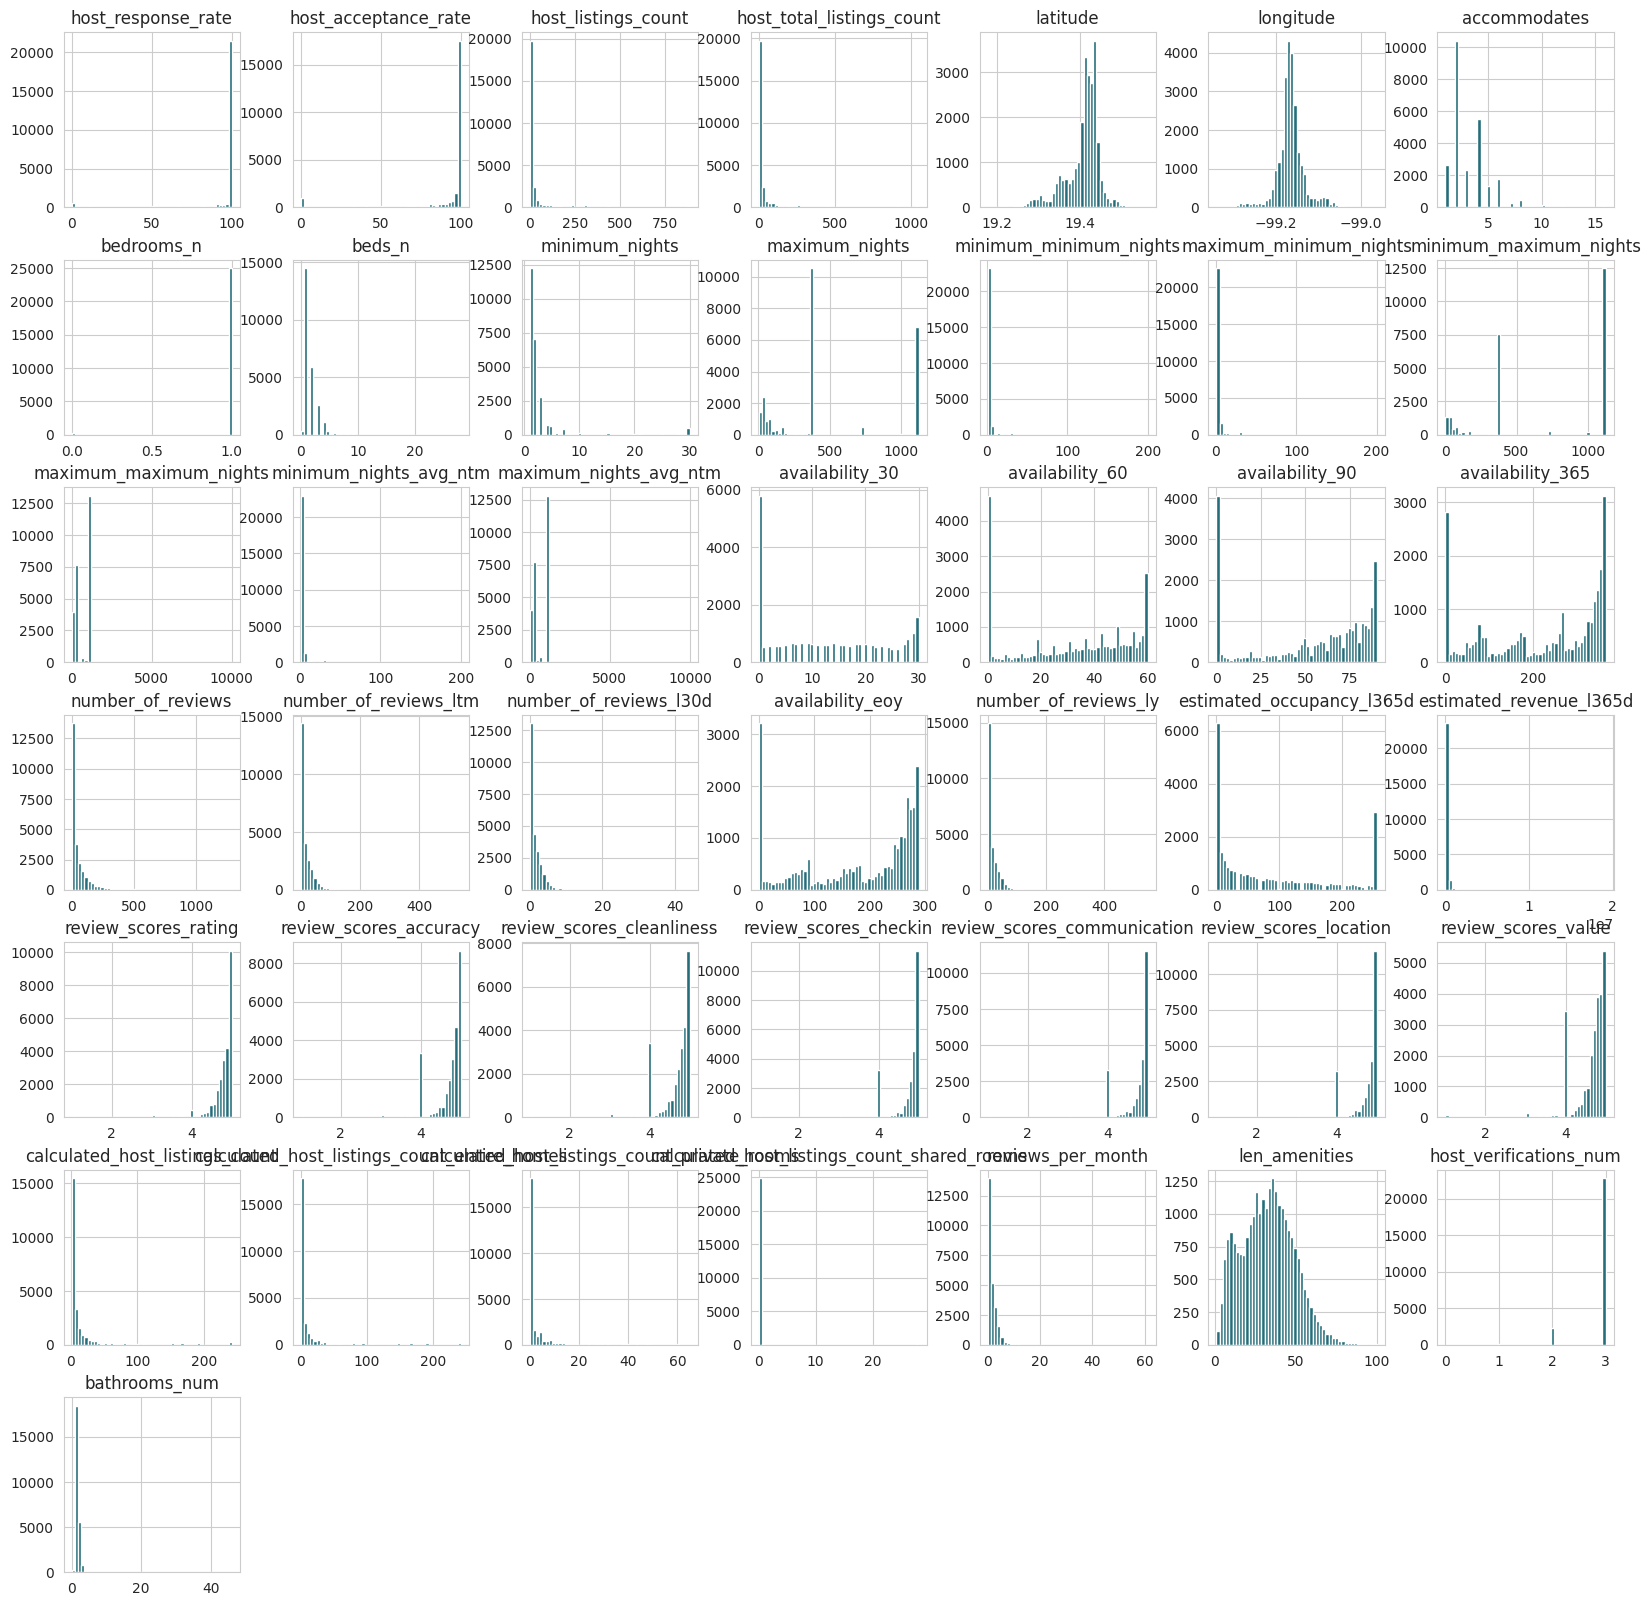

In [41]:
listings[ var_cont ].hist(bins=50, figsize=(20,20), color='#256D7B')
plt.show()

#### Variable objetivo numerica

<Figure size 500x500 with 0 Axes>

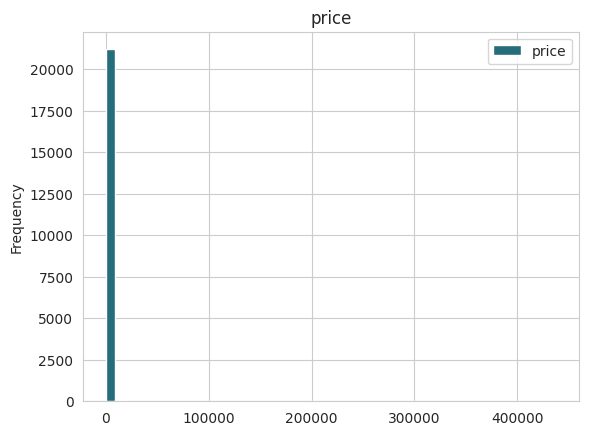

In [42]:
# hisplot and boxplot of listings variables nums
plt.figure( figsize=(5, 5) )
listings[ var_obj_num ].plot(kind='hist', bins=50, color='#256D7B')
plt.title(f"price")
plt.show()

In [43]:
listings[ var_obj_num[0] ].describe(percentiles=[0.01, .25, .5, .75, .99, .999])

count    21338.00
mean      1500.58
std       3813.94
min        116.00
1%         224.00
25%        630.00
50%       1045.00
75%       1678.00
99%       7278.78
99.9%    27221.52
max     438053.00
Name: price, dtype: float64

In [44]:
print(listings.shape)
print(listings[ listings['price'] > listings['price'].quantile(.99) ].shape)
print(listings[listings['price'] <= listings['price'].quantile(.99)].shape)
print(listings[ ~(listings['price'] > listings['price'].quantile(.99))].shape)

(25218, 88)
(214, 88)
(21124, 88)
(25004, 88)


In [45]:
# Registro con el valor mas alto
listings[ listings[var_obj_num[0]] == 438053.00 ]

id                                       listing_url  \
24145  1303619093372835080  https://www.airbnb.com/rooms/1303619093372835080   

            scrape_id last_scraped       source  \
24145  20250319150644   2025-03-21  city scrape   

                                             name  \
24145  Navidad en Depto. Premium Cerca de Polanco   

                                             description  \
24145  The Carso Condominiums, shielded under the ren...   

      neighborhood_overview  \
24145                   NaN   

                                             picture_url    host_id  \
24145  https://a0.muscache.com/pictures/prohost-api/H...  104400812   

                                          host_url host_name host_since  \
24145  https://www.airbnb.com/users/show/104400812    Stefan 2016-11-19   

             host_location                                         host_about  \
24145  Mexico City, Mexico  Soy una persona alegre, divertida y cuidadosa....   

      host_response_time  host_response_rate  host_acceptance_rate  \
24145     within an hour               96.00                 99.00   

      host_is_superhost                                 host_thumbnail_url  \
24145                 f  https://a0.muscache.com/im/pictures/user/User/...   

                                        host_picture_url host_neighbourhood  \
24145  https://a0.muscache.com/im/pictures/user/User/...           Santa Fe   

       host_listings_count  host_total_listings_count  host_verifications  \
24145                22.00                      28.00  ['email', 'phone']   

      host_has_profile_pic host_identity_verified neighbourhood  \
24145                    t                      t           NaN   

      neighbourhood_cleansed  neighbourhood_group_cleansed  latitude  \
24145         Miguel Hidalgo                           NaN     19.45   

       longitude       property_type        room_type  accommodates  \
24145     -99.22  Entire rental unit  Entire home/apt             3   

       bathrooms bathrooms_text  bedrooms  beds  \
24145       1.50      1.5 baths      1.00  2.00   

                                               amenities     price  \
24145  ["Wifi", "Pool", "Self check-in", "Free parkin... 438053.00   

       minimum_nights  maximum_nights  minimum_minimum_nights  \
24145               1              90                       1   

       maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
24145                       1                    1125                    1125   

       minimum_nights_avg_ntm  maximum_nights_avg_ntm  calendar_updated  \
24145                    1.00                 1125.00               NaN   

      has_availability  availability_30  availability_60  availability_90  \
24145                t                0                0                0   

       availability_365 calendar_last_scraped  number_of_reviews  \
24145                45            2025-03-21                  3   

       number_of_reviews_ltm  number_of_reviews_l30d  availability_eoy  \
24145                      3                       0                 0   

       number_of_reviews_ly  estimated_occupancy_l365d  \
24145                     1                         18   

       estimated_revenue_l365d first_review last_review  review_scores_rating  \
24145               7884954.00   2024-12-28  2025-02-06                  5.00   

       review_scores_accuracy  review_scores_cleanliness  \
24145                    5.00                       5.00   

       review_scores_checkin  review_scores_communication  \
24145                   5.00                         5.00   

       review_scores_location  review_scores_value  license instant_bookable  \
24145                    5.00                 5.00      NaN                t   

       calculated_host_listings_count  \
24145                              21   

       calculated_host_listings_count_entire_homes  \
24145                    

In [46]:
listings = listings[ ~(listings['price'] > listings['price'].quantile(.99))]
listings.shape

(25004, 88)

<Figure size 500x500 with 0 Axes>

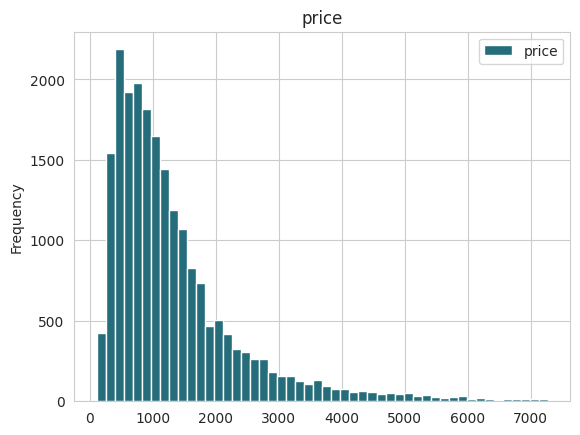

In [47]:
# hisplot and boxplot of listings variables nums
plt.figure( figsize=(5, 5) )
listings[ var_obj_num ].plot(kind='hist', bins=50, color='#256D7B')
plt.title(f"price")
plt.show()

In [48]:
listings['price'].describe(percentiles=[0.01, .25, .5, .75, .99, .999])

count   21124.00
mean     1339.11
std      1066.50
min       116.00
1%        223.23
25%       630.00
50%      1035.00
75%      1647.00
99%      5545.85
99.9%    7082.28
max      7275.00
Name: price, dtype: float64

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
pandas 2.2.2
geopandas 1.0.1
numpy 2.0.2
matplotlib 3.10.0


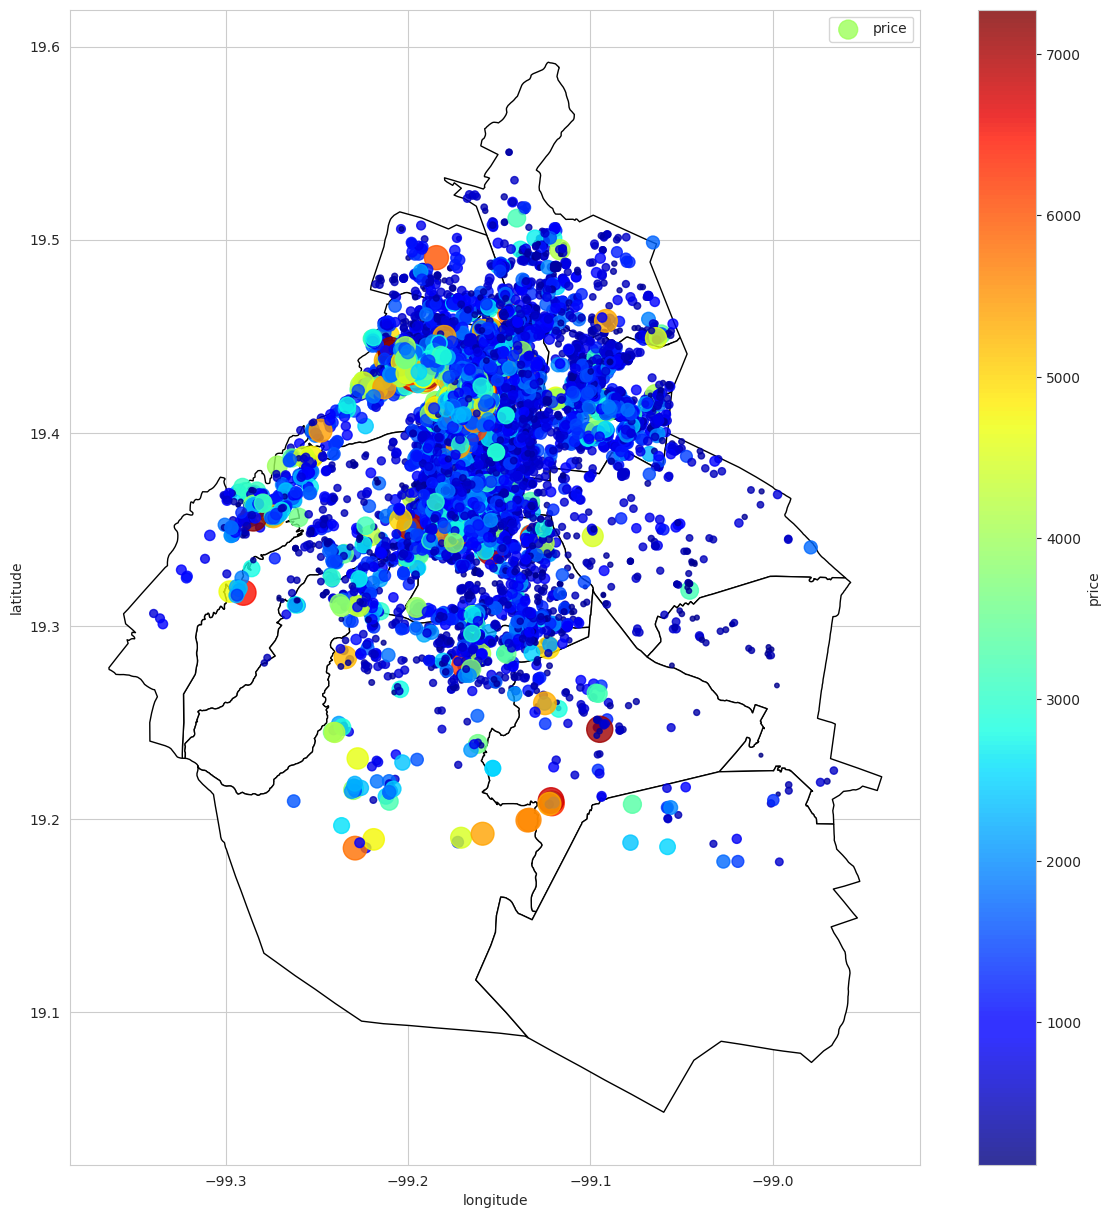

In [49]:
from math import ceil
import sys
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print(sys.version)
print(pd.__name__, pd.__version__)
print(gpd.__name__, gpd.__version__)
print(np.__name__, np.__version__)
print(plt.matplotlib.__name__, plt.matplotlib.__version__)

cdmx = gpd.read_file('/content/drive/MyDrive/DataScience/data/mapa_mexico')\
    .query('CVE_EDO=="09"')\
    .set_index('CLAVE')

base = cdmx.plot(color='white', edgecolor='black', scheme="naturalbreaks")

above = listings.plot(kind='scatter',
            x='longitude',
            y='latitude',
            alpha=0.8,
            ax=base,
            s=listings['price']*.05,
            label="price",
            figsize=(15, 15),
            c='price',
            cmap=plt.get_cmap('jet'),
            colorbar=True)


plt.show()

In [50]:
print(listings.shape)
print(listings[listings['price'].isna()].shape)
print(listings[~listings['price'].isna()].shape)

(25004, 88)
(3880, 88)
(21124, 88)


In [51]:
listings = listings[ ~listings['price'].isna() ]
listings.shape

(21124, 88)

### Variables discretas

In [52]:
listings[ var_disc ].describe(include='all').T

count unique                 top   freq mean  \
host_name                       21119   3528           Alejandra    302  NaN   
host_response_time              19521      4      within an hour  16133  NaN   
host_is_superhost               20007      2                   f  11599  NaN   
host_has_profile_pic            21119      2                   t  20690  NaN   
host_identity_verified          21119      2                   t  20758  NaN   
neighbourhood_cleansed          21124     16          Cuauhtémoc   9896  NaN   
property_type                   21124     74  Entire rental unit   8376  NaN   
room_type                       21124      4     Entire home/apt  14203  NaN   
has_availability                20945      1                   t  20945  NaN   
host_verifications_email     21124.00    NaN                 NaN    NaN 0.91   
host_verifications_phone     21124.00    NaN                 NaN    NaN 1.00   
host_verifications_workemail 21124.00    NaN                 NaN    NaN 0.13   
host_in_location             21124.00    NaN                 NaN    NaN 0.76   

                              std  min  25%  50%  75%  max  
host_name                     NaN  NaN  NaN  NaN  NaN  NaN  
host_response_time            NaN  NaN  NaN  NaN  NaN  NaN  
host_is_superhost             NaN  NaN  NaN  NaN  NaN  NaN  
host_has_profile_pic          NaN  NaN  NaN  NaN  NaN  NaN  
host_identity_verified        NaN  NaN  NaN  NaN  NaN  NaN  
neighbourhood_cleansed        NaN  NaN  NaN  NaN  NaN  NaN  
property_type                 NaN  NaN  NaN  NaN  NaN  NaN  
room_type                     NaN  NaN  NaN  NaN  NaN  NaN  
has_availability              NaN  NaN  NaN  NaN  NaN  NaN  
host_verifications_email     0.28 0.00 1.00 1.00 1.00 1.00  
host_verifications_phone     0.04 0.00 1.00 1.00 1.00 1.00  
host_verifications_workemail 0.34 0.00 0.00 0.00 0.00 1.00  
host_in_location             0.43 0.00 1.00 1.00 1.00 1.00

In [53]:
listings[ var_disc ].isna().sum() / listings.shape[0]*100

host_name                      0.02
host_response_time             7.59
host_is_superhost              5.29
host_has_profile_pic           0.02
host_identity_verified         0.02
neighbourhood_cleansed         0.00
property_type                  0.00
room_type                      0.00
has_availability               0.85
host_verifications_email       0.00
host_verifications_phone       0.00
host_verifications_workemail   0.00
host_in_location               0.00
dtype: float64

In [54]:
listings['host_name'] = listings['host_name'].fillna('sin_registro')
listings['host_response_time'] = listings['host_response_time'].fillna('sin_registro')
listings['host_is_superhost'] = listings['host_is_superhost'].fillna('sin_registro')
listings['host_has_profile_pic'] = listings['host_has_profile_pic'].fillna('sin_registro')
listings['host_identity_verified'] = listings['host_identity_verified'].fillna('sin_registro')
listings['has_availability'] = listings['has_availability'].fillna('sin_registro')

In [55]:
listings[ var_disc ].isna().sum() / listings.shape[0]*100

host_name                      0.00
host_response_time             0.00
host_is_superhost              0.00
host_has_profile_pic           0.00
host_identity_verified         0.00
neighbourhood_cleansed         0.00
property_type                  0.00
room_type                      0.00
has_availability               0.00
host_verifications_email       0.00
host_verifications_phone       0.00
host_verifications_workemail   0.00
host_in_location               0.00
dtype: float64

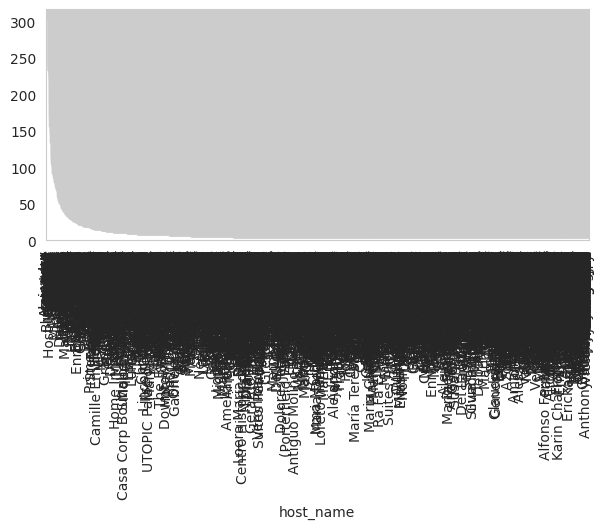

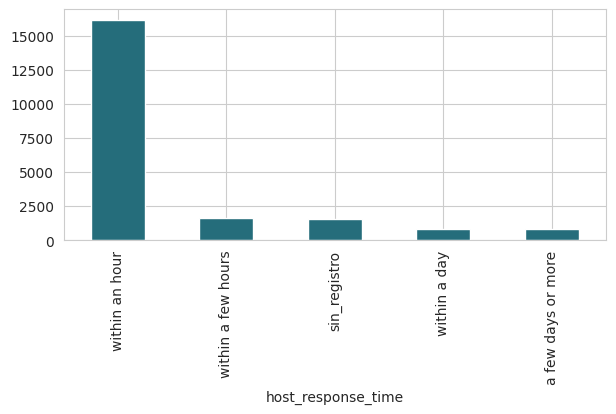

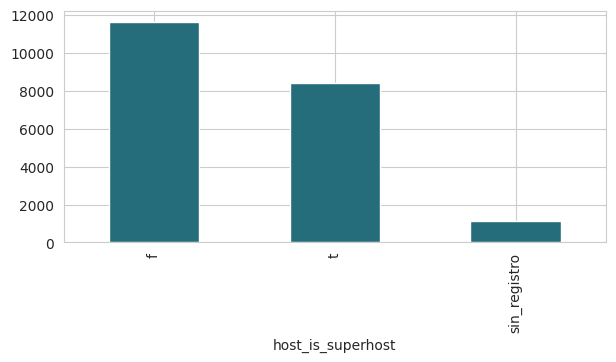

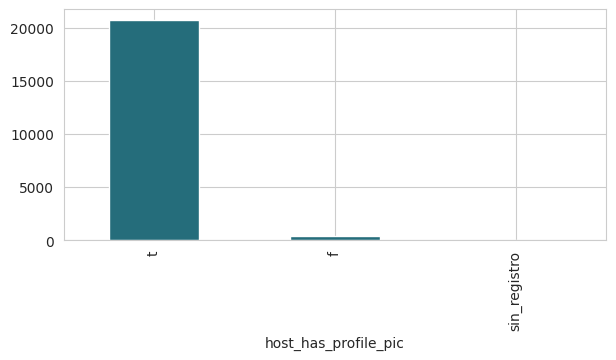

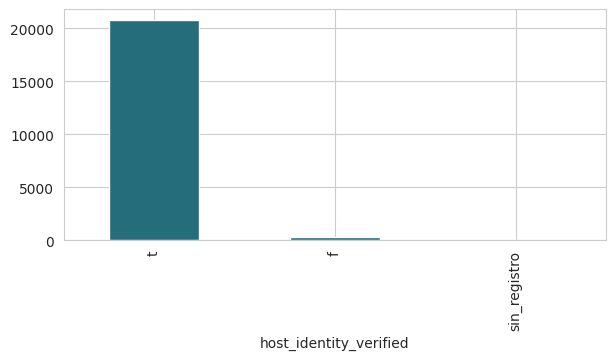

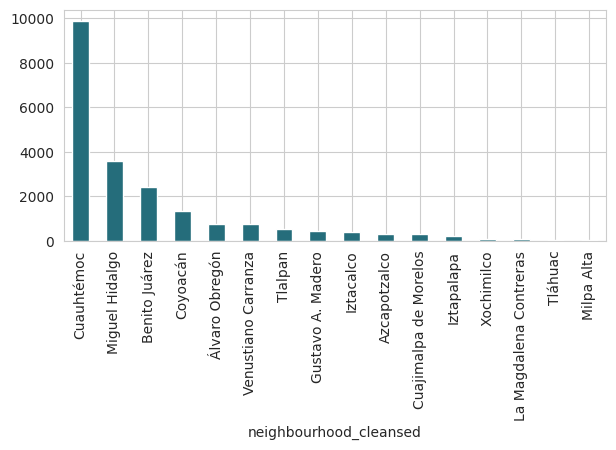

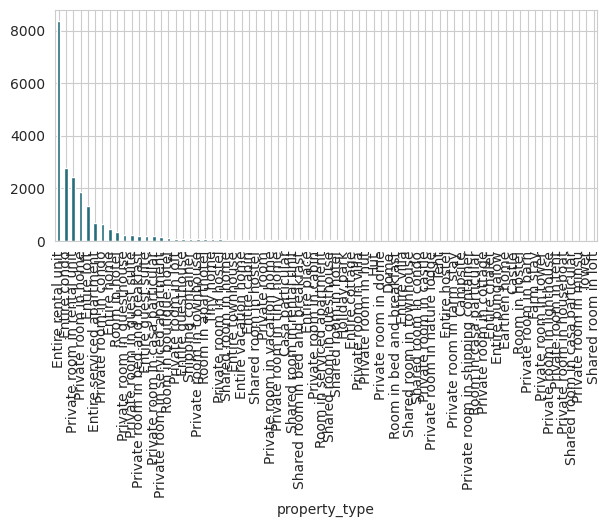

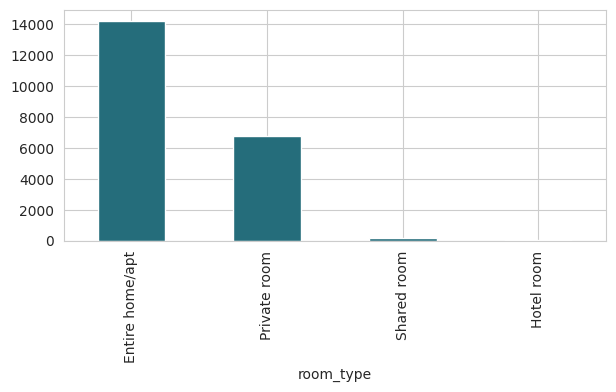

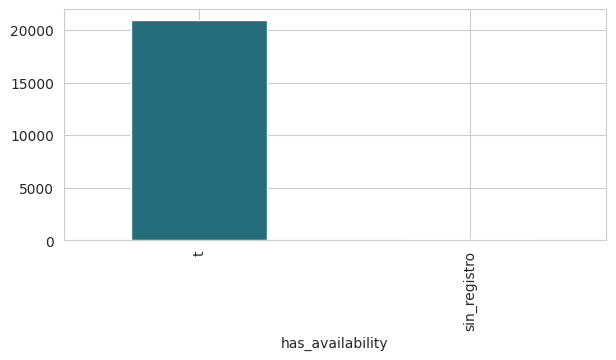

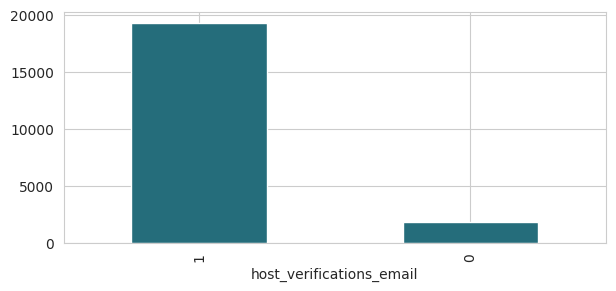

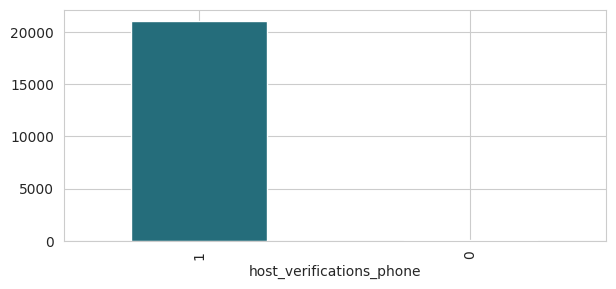

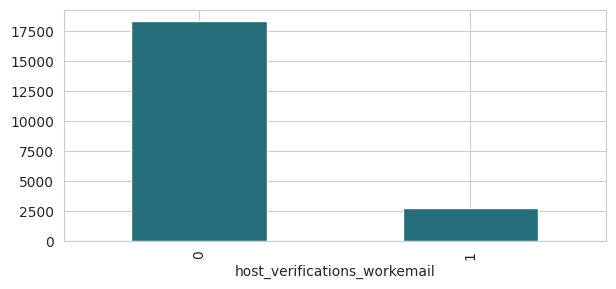

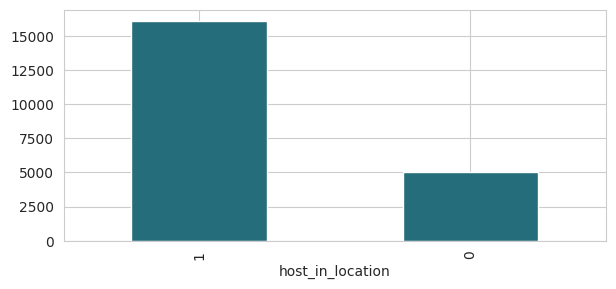

In [56]:
for x in var_disc:
    plt.figure(figsize=(7, 3))
    listings[x].value_counts().plot(kind='bar', color='#256D7B')
    plt.show()

In [57]:
def freq(df, var):
    if type(var) != list:
        var = [var]
    for v in var:
        #v = 'state'
        aux = df[v].value_counts().to_frame().rename(columns={'count':'FA'})
        aux['FR'] = aux['FA'] / aux['FA'].sum()
        aux[['FAA','FRA']] = aux.apply(  np.cumsum )
        print(f"La variable: {v}")
        display(aux)
        print("\n")

freq(listings, var=var_disc)

La variable: host_name


FA   FR    FAA  FRA
host_name                           
Alejandra       302 0.01    302 0.01
Alejandro       238 0.01    540 0.03
Juan            232 0.01    772 0.04
Blueground      224 0.01    996 0.05
Raul            220 0.01   1216 0.06
...             ...  ...    ...  ...
Jocelyn Marian    1 0.00  21120 1.00
Norma Olivia      1 0.00  21121 1.00
Yihao             1 0.00  21122 1.00
Rodrigo Jair      1 0.00  21123 1.00
Jesus Hiram       1 0.00  21124 1.00

[3529 rows x 4 columns]



La variable: host_response_time


FA   FR    FAA  FRA
host_response_time                        
within an hour      16133 0.76  16133 0.76
within a few hours   1659 0.08  17792 0.84
sin_registro         1603 0.08  19395 0.92
within a day          875 0.04  20270 0.96
a few days or more    854 0.04  21124 1.00



La variable: host_is_superhost


FA   FR    FAA  FRA
host_is_superhost                        
f                  11599 0.55  11599 0.55
t                   8408 0.40  20007 0.95
sin_registro        1117 0.05  21124 1.00



La variable: host_has_profile_pic


FA   FR    FAA  FRA
host_has_profile_pic                        
t                     20690 0.98  20690 0.98
f                       429 0.02  21119 1.00
sin_registro              5 0.00  21124 1.00



La variable: host_identity_verified


FA   FR    FAA  FRA
host_identity_verified                        
t                       20758 0.98  20758 0.98
f                         361 0.02  21119 1.00
sin_registro                5 0.00  21124 1.00



La variable: neighbourhood_cleansed


FA   FR    FAA  FRA
neighbourhood_cleansed                       
Cuauhtémoc              9896 0.47   9896 0.47
Miguel Hidalgo          3593 0.17  13489 0.64
Benito Juárez           2422 0.11  15911 0.75
Coyoacán                1325 0.06  17236 0.82
Álvaro Obregón           770 0.04  18006 0.85
Venustiano Carranza      730 0.03  18736 0.89
Tlalpan                  547 0.03  19283 0.91
Gustavo A. Madero        415 0.02  19698 0.93
Iztacalco                378 0.02  20076 0.95
Azcapotzalco             312 0.01  20388 0.97
Cuajimalpa de Morelos    292 0.01  20680 0.98
Iztapalapa               204 0.01  20884 0.99
Xochimilco                98 0.00  20982 0.99
La Magdalena Contreras    90 0.00  21072 1.00
Tláhuac                   31 0.00  21103 1.00
Milpa Alta                21 0.00  21124 1.00



La variable: property_type


FA   FR    FAA  FRA
property_type                                        
Entire rental unit              8376 0.40   8376 0.40
Entire condo                    2776 0.13  11152 0.53
Private room in rental unit     2412 0.11  13564 0.64
Private room in home            1873 0.09  15437 0.73
Entire loft                     1313 0.06  16750 0.79
...                              ...  ...    ...  ...
Private room in houseboat          1 0.00  21120 1.00
Shared room in casa particular     1 0.00  21121 1.00
Private room in minsu              1 0.00  21122 1.00
Tower                              1 0.00  21123 1.00
Shared room in loft                1 0.00  21124 1.00

[74 rows x 4 columns]



La variable: room_type


FA   FR    FAA  FRA
room_type                              
Entire home/apt  14203 0.67  14203 0.67
Private room      6726 0.32  20929 0.99
Shared room        147 0.01  21076 1.00
Hotel room          48 0.00  21124 1.00



La variable: has_availability


FA   FR    FAA  FRA
has_availability                        
t                 20945 0.99  20945 0.99
sin_registro        179 0.01  21124 1.00



La variable: host_verifications_email


FA   FR    FAA  FRA
host_verifications_email                        
1                         19287 0.91  19287 0.91
0                          1837 0.09  21124 1.00



La variable: host_verifications_phone


FA   FR    FAA  FRA
host_verifications_phone                        
1                         21084 1.00  21084 1.00
0                            40 0.00  21124 1.00



La variable: host_verifications_workemail


FA   FR    FAA  FRA
host_verifications_workemail                        
0                             18375 0.87  18375 0.87
1                              2749 0.13  21124 1.00



La variable: host_in_location


FA   FR    FAA  FRA
host_in_location                        
1                 16121 0.76  16121 0.76
0                  5003 0.24  21124 1.00

In [58]:
def normalizar(df, v, umbral):
    #umbral = 0.03 # 0.05
    aux = df[v].value_counts(True).to_frame()
    aux[f"n__{v}"] = np.where( aux['proportion'] < umbral , 'CAT_PEQUE' ,aux.index )

    moda  = aux.head()[f'n__{v}'].values[0]

    if aux.loc[ aux[f'n__{v}'] == 'CAT_PEQUE' ]['proportion'].sum() < umbral:
        aux[f'n__{v}'].replace({'CAT_PEQUE':moda},inplace=True)

    aux.reset_index(inplace=True)

    return df.merge( aux , left_on=[v] , right_on=[v] , how='left' ).drop('proportion',axis=1)

umbral = 0.05
for v in var_disc:
    print(f"Normalizando: {v}")
    listings =  normalizar( listings , v, umbral)

Normalizando: host_name
Normalizando: host_response_time
Normalizando: host_is_superhost
Normalizando: host_has_profile_pic
Normalizando: host_identity_verified
Normalizando: neighbourhood_cleansed
Normalizando: property_type
Normalizando: room_type
Normalizando: has_availability
Normalizando: host_verifications_email
Normalizando: host_verifications_phone
Normalizando: host_verifications_workemail
Normalizando: host_in_location


In [59]:
print(listings.shape)

(21124, 101)


In [60]:
var_disc = listings.filter(like='n__').columns.to_list()
var_disc

['n__host_name',
 'n__host_response_time',
 'n__host_is_superhost',
 'n__host_has_profile_pic',
 'n__host_identity_verified',
 'n__neighbourhood_cleansed',
 'n__property_type',
 'n__room_type',
 'n__has_availability',
 'n__host_verifications_email',
 'n__host_verifications_phone',
 'n__host_verifications_workemail',
 'n__host_in_location']

In [61]:
freq( listings, var_disc)

La variable: n__host_name


FA   FR    FAA  FRA
n__host_name                        
CAT_PEQUE     21124 1.00  21124 1.00



La variable: n__host_response_time


FA   FR    FAA  FRA
n__host_response_time                        
within an hour         16133 0.76  16133 0.76
CAT_PEQUE               1729 0.08  17862 0.85
within a few hours      1659 0.08  19521 0.92
sin_registro            1603 0.08  21124 1.00



La variable: n__host_is_superhost


FA   FR    FAA  FRA
n__host_is_superhost                        
f                     11599 0.55  11599 0.55
t                      8408 0.40  20007 0.95
sin_registro           1117 0.05  21124 1.00



La variable: n__host_has_profile_pic


FA   FR    FAA  FRA
n__host_has_profile_pic                        
t                        21124 1.00  21124 1.00



La variable: n__host_identity_verified


FA   FR    FAA  FRA
n__host_identity_verified                        
t                          21124 1.00  21124 1.00



La variable: n__neighbourhood_cleansed


FA   FR    FAA  FRA
n__neighbourhood_cleansed                       
Cuauhtémoc                 9896 0.47   9896 0.47
CAT_PEQUE                  3888 0.18  13784 0.65
Miguel Hidalgo             3593 0.17  17377 0.82
Benito Juárez              2422 0.11  19799 0.94
Coyoacán                   1325 0.06  21124 1.00



La variable: n__property_type


FA   FR    FAA  FRA
n__property_type                                  
Entire rental unit           8376 0.40   8376 0.40
CAT_PEQUE                    4374 0.21  12750 0.60
Entire condo                 2776 0.13  15526 0.73
Private room in rental unit  2412 0.11  17938 0.85
Private room in home         1873 0.09  19811 0.94
Entire loft                  1313 0.06  21124 1.00



La variable: n__room_type


FA   FR    FAA  FRA
n__room_type                           
Entire home/apt  14398 0.68  14398 0.68
Private room      6726 0.32  21124 1.00



La variable: n__has_availability


FA   FR    FAA  FRA
n__has_availability                        
t                    21124 1.00  21124 1.00



La variable: n__host_verifications_email


FA   FR    FAA  FRA
n__host_verifications_email                        
1                            19287 0.91  19287 0.91
0                             1837 0.09  21124 1.00



La variable: n__host_verifications_phone


FA   FR    FAA  FRA
n__host_verifications_phone                        
1                            21124 1.00  21124 1.00



La variable: n__host_verifications_workemail


FA   FR    FAA  FRA
n__host_verifications_workemail                        
0                                18375 0.87  18375 0.87
1                                 2749 0.13  21124 1.00



La variable: n__host_in_location


FA   FR    FAA  FRA
n__host_in_location                        
1                    16121 0.76  16121 0.76
0                     5003 0.24  21124 1.00

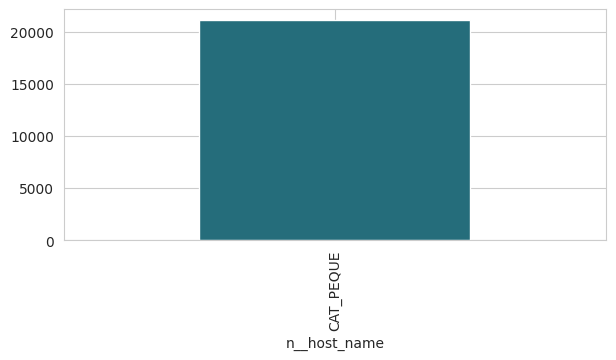

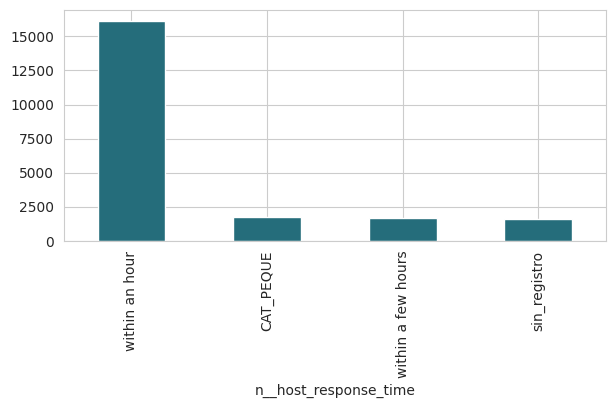

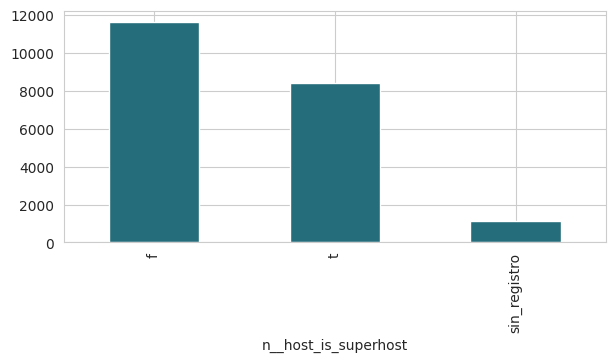

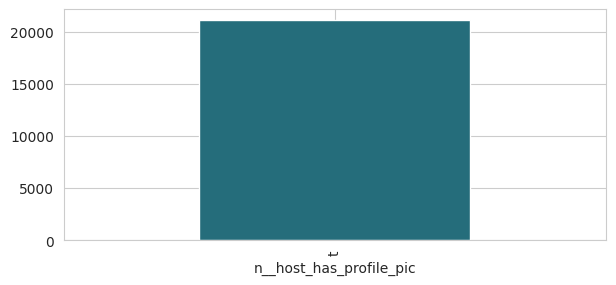

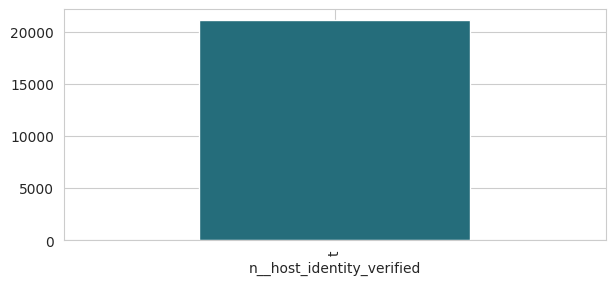

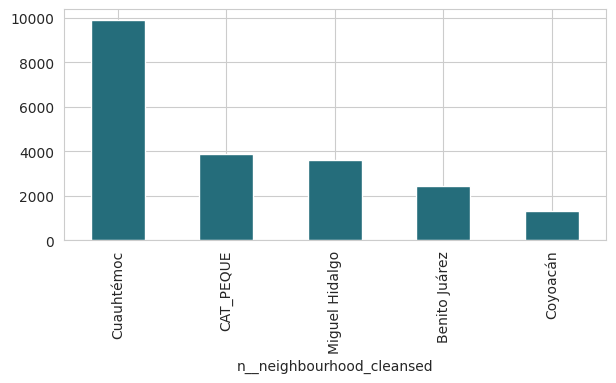

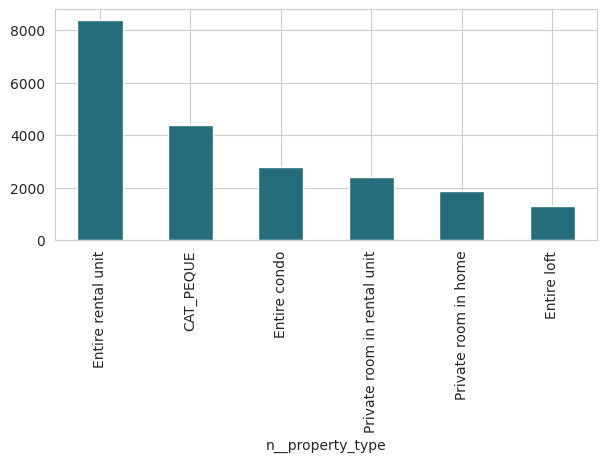

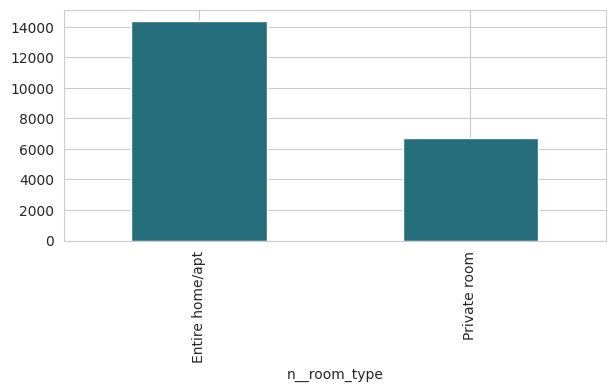

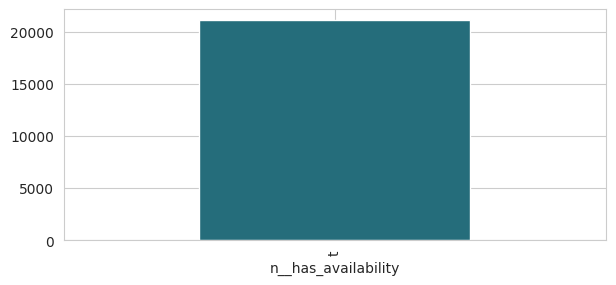

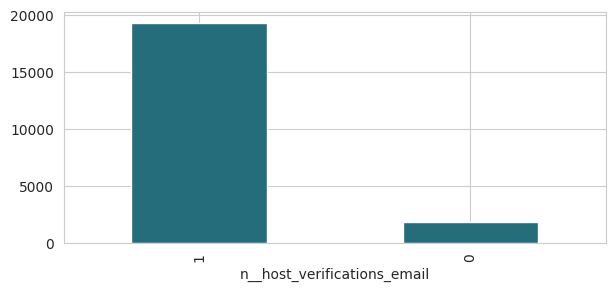

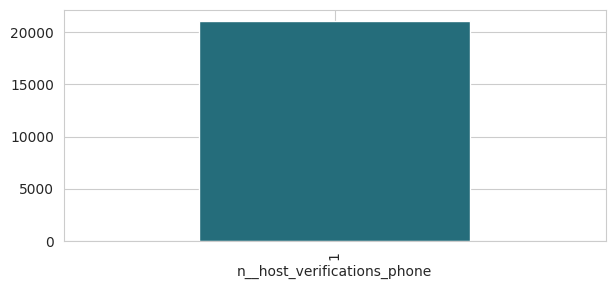

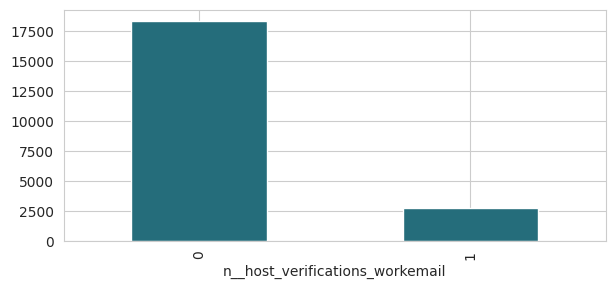

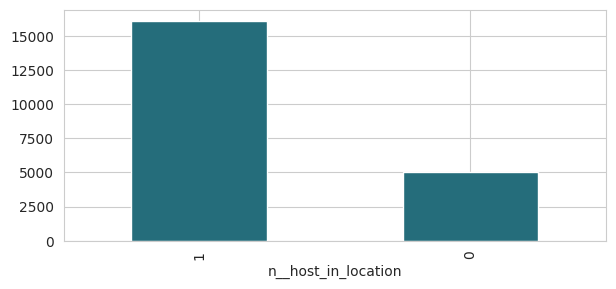

In [62]:
for x in var_disc:
    plt.figure(figsize=(7, 3))
    listings[x].value_counts().plot(kind='bar', color='#256D7B')
    plt.show()

In [63]:
# variables categoricas que solo tienen una "categoria" o un valor unico
unarias = [v for v, cont in zip( var_disc, [ listings[v].unique().shape[0] for v in var_disc ] ) if cont == 1]
unarias

['n__host_name',
 'n__host_has_profile_pic',
 'n__host_identity_verified',
 'n__has_availability',
 'n__host_verifications_phone']

In [64]:
var_disc = [ _ for _ in var_disc if _ not in unarias]
var_disc

['n__host_response_time',
 'n__host_is_superhost',
 'n__neighbourhood_cleansed',
 'n__property_type',
 'n__room_type',
 'n__host_verifications_email',
 'n__host_verifications_workemail',
 'n__host_in_location']

In [65]:
listings[var_disc].isnull().sum() / len(listings) *100

n__host_response_time             0.00
n__host_is_superhost              0.00
n__neighbourhood_cleansed         0.00
n__property_type                  0.00
n__room_type                      0.00
n__host_verifications_email       0.00
n__host_verifications_workemail   0.00
n__host_in_location               0.00
dtype: float64

### Variable objetivo discreta

In [66]:
listings.shape

(21124, 101)

In [67]:
listings[ ['availability_30', 'availability_60', 'availability_90', 'availability_365'] ].describe(percentiles=[0.01, .1, .25, .5, .75, .99])

availability_30  availability_60  availability_90  availability_365
count         21124.00         21124.00         21124.00          21124.00
mean             13.82            35.57            59.72            238.56
std              10.16            19.29            27.63            115.96
min               0.00             0.00             0.00              0.00
1%                0.00             0.00             0.00              0.00
10%               0.00             1.00             9.00             63.00
25%               4.00            21.00            46.00            143.00
50%              13.00            40.00            68.00            269.00
75%              23.00            52.00            82.00            346.00
99%              30.00            60.00            90.00            365.00
max              30.00            60.00            90.00            365.00

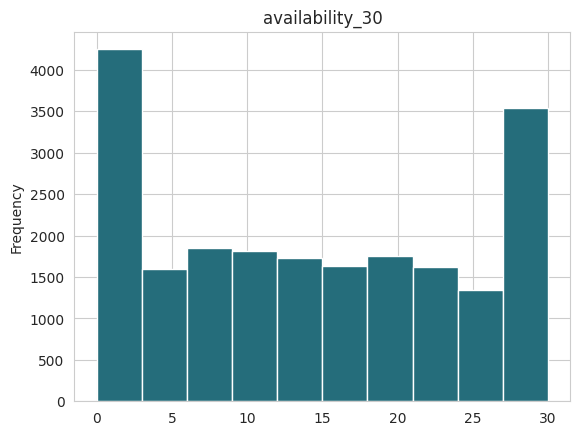

In [68]:
listings['availability_30'].plot(kind='hist', color='#256D7B')
plt.title('availability_30')
plt.show()

In [69]:
listings[listings['availability_30'] > 0][['id', 'availability_30', 'availability_60', 'availability_90', 'availability_365']].sample(3)

id  availability_30  availability_60  availability_90  \
17925  1224882245972706289                5                5                5   
1650              19946005               19               49               70   
6547              49650118               25               55               85   

       availability_365  
17925                51  
1650                155  
6547                 85

In [70]:
#df = calendar[calendar['listing_id'] == 1135456540933287551]
#plt.figure(figsize=(15, 3))
#plt.plot(df['date'], df['available'])
#plt.show()

In [71]:
listings[listings['id'] == 1135456540933287551][['id', 'availability_30', 'availability_60', 'availability_90', 'availability_365']]

id  availability_30  availability_60  availability_90  \
16172  1135456540933287551                9               35               65   

       availability_365  
16172               248

In [72]:
listings[listings['id'] == 1135456540933287551][['availability_30', 'availability_60', 'availability_90', 'availability_365']].sum(axis=1)

16172    357
dtype: int64

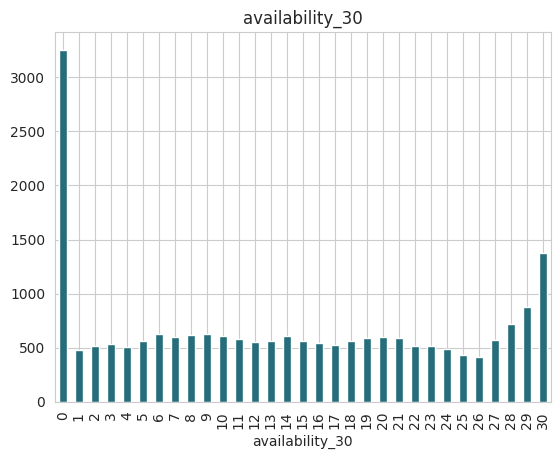

In [73]:
listings['availability_30'].value_counts().sort_index().plot(kind='bar', color='#256D7B')
plt.title('availability_30')
plt.show()

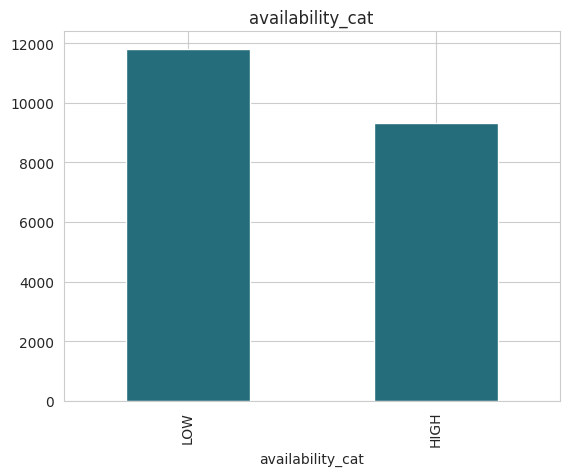

In [74]:
listings['availability_cat'] = listings['availability_30'].map(lambda x: 'HIGH' if x > 15 else 'LOW')
listings['availability_cat'].value_counts().plot(kind='bar', color='#256D7B')
plt.title('availability_cat')
plt.show()

In [75]:
var_disc

['n__host_response_time',
 'n__host_is_superhost',
 'n__neighbourhood_cleansed',
 'n__property_type',
 'n__room_type',
 'n__host_verifications_email',
 'n__host_verifications_workemail',
 'n__host_in_location']

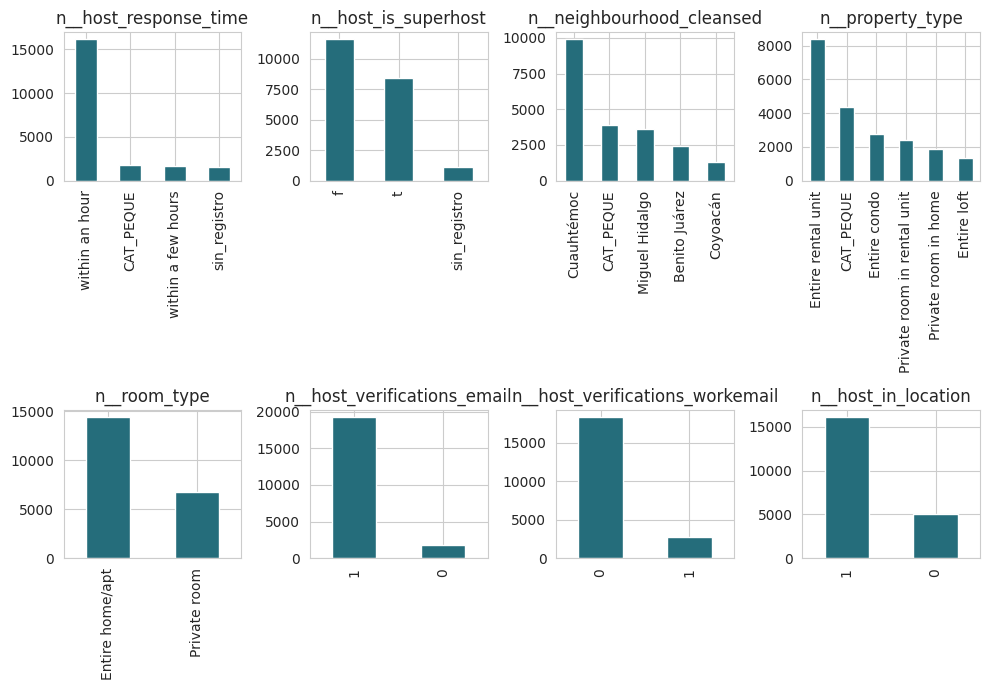

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que tienes hasta 8 variables en var_disc
fig, axes = plt.subplots(2, 4, figsize=(10, 7))  # 4 filas, 2 columnas
axes = axes.flatten()  # Para poder iterar fácilmente

# Iteramos sobre las variables y ejes
for i, var in enumerate(var_disc):
    if i >= 8:  # Por si hay más de 8 variables, ignora el resto
        break
    ax = axes[i]
    listings[var].value_counts().plot(kind='bar', color='#256D7B', ax=ax)
    ax.set_title(f'{var}')
    ax.set_xlabel('')
    ax.set_ylabel('')

# Eliminar ejes no usados (si hay menos de 8 variables)
for j in range(len(var_disc), 8):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

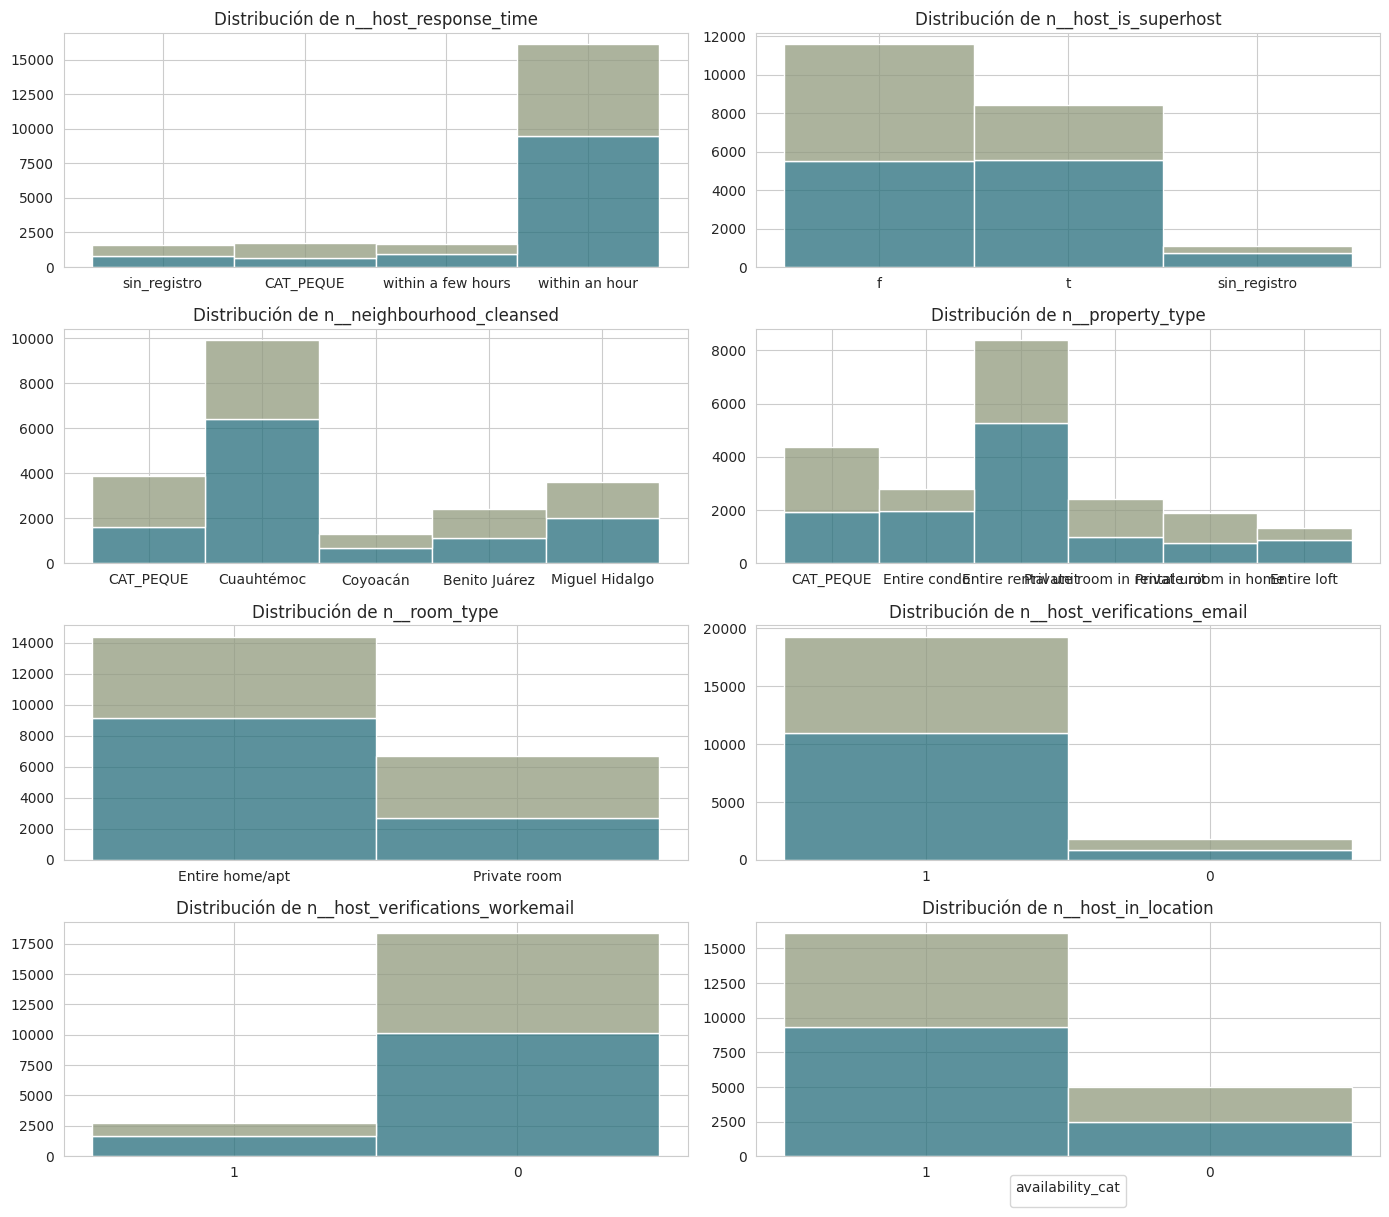

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que tienes hasta 8 variables en var_disc
fig, axes = plt.subplots(4, 2, figsize=(14, 12))  # 4 filas, 2 columnas
axes = axes.flatten()  # Para poder iterar fácilmente

# Paleta de colores personalizada (opcional)
palette_dict = {
    'HIGH': '#909a7D',   # verde
    'LOW': '#256D7B'    # rojo
}

# Iteramos sobre las variables y ejes
for i, var in enumerate(var_disc):
    if i >= 8:  # Por si hay más de 8 variables, ignora el resto
        break
    ax = axes[i]
    sns.histplot(data=listings, x=var, hue='availability_cat', multiple='stack',
                 legend=False, palette=palette_dict, ax=ax)
    ax.set_title(f'Distribución de {var}')
    ax.set_xlabel('')
    ax.set_ylabel('')

# Eliminar ejes no usados (si hay menos de 8 variables)
for j in range(len(var_disc), 8):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.legend(title='availability_cat', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
plt.show()

<Axes: >

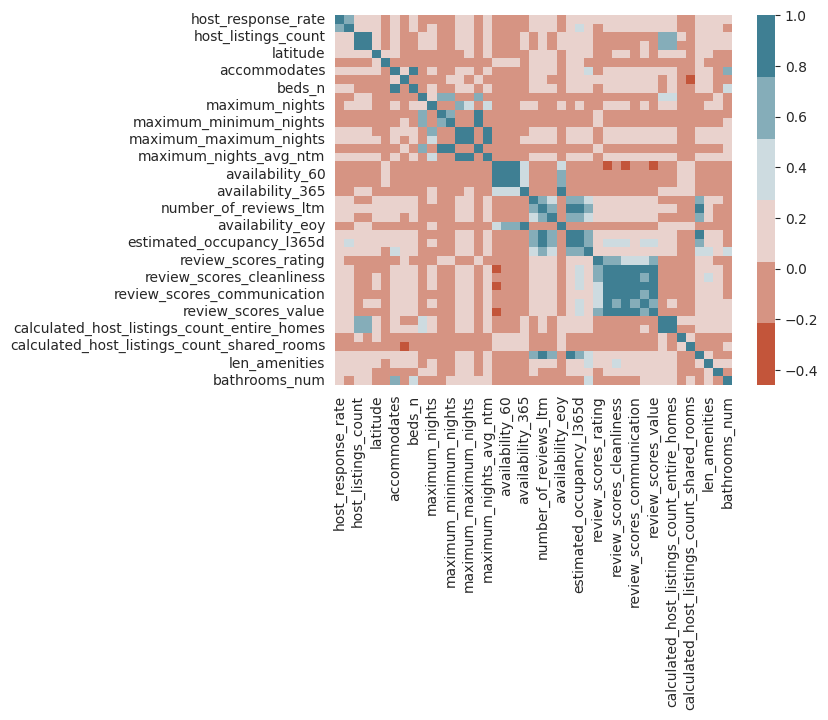

In [78]:
sns.heatmap(listings[var_cont].corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220))

In [79]:
listings[var_cont].shape

(21124, 43)

## Modelos

#### Regression

##### Mejores variables

In [145]:
# Preparacion de sets
X = listings.drop( columns=var_disc)[var_cont].join(pd.get_dummies(listings[var_disc], drop_first=True))
y = listings[var_obj_num]

In [146]:
print(X.shape)
print(y.shape)

(21124, 61)
(21124, 1)


In [147]:
assert X.shape == (21124, 61)

In [83]:
"""from sklearn.feature_selection import SelectKBest, f_regression, f_classif

kb = SelectKBest( k=30, score_func=f_regression )
kb.fit(X, y)

ls_best = [x for x, y in zip(X.columns, kb.get_support()) if y]
print(ls_best)

X = pd.DataFrame(kb.transform(X), columns=ls_best)"""

'from sklearn.feature_selection import SelectKBest, f_regression, f_classif\n\nkb = SelectKBest( k=30, score_func=f_regression )\nkb.fit(X, y)\n\nls_best = [x for x, y in zip(X.columns, kb.get_support()) if y]\nprint(ls_best)\n\nX = pd.DataFrame(kb.transform(X), columns=ls_best)'

In [148]:
X.describe(percentiles=[0.01, .1, .25, .5, .75, .99])

host_response_rate  host_acceptance_rate  host_listings_count  \
count            21124.00              21124.00             21124.00   
mean                94.67                 90.22                27.95   
std                 18.65                 23.11                91.87   
min                  0.00                  0.00                 0.00   
1%                   0.00                  0.00                 1.00   
10%                 90.00                 70.00                 1.00   
25%                100.00                 95.00                 2.00   
50%                100.00                 99.00                 4.00   
75%                100.00                100.00                15.00   
99%                100.00                100.00               442.00   
max                100.00                100.00               886.00   

       host_total_listings_count  latitude  longitude  accommodates  \
count                   21124.00  21124.00   21124.00      21124.00   
mean                       37.70     19.41     -99.17          3.21   
std                       129.95      0.04       0.03          1.94   
min                         0.00     19.18     -99.34          1.00   
1%                          1.00     19.27     -99.27          1.00   
10%                         1.00     19.35     -99.20          2.00   
25%                         2.00     19.39     -99.18          2.00   
50%                         6.00     19.42     -99.17          2.00   
75%                        18.00     19.43     -99.15          4.00   
99%                       913.00     19.49     -99.07         10.00   
max                      1049.00     19.55     -98.97         16.00   

       bedrooms_n   beds_n  minimum_nights  maximum_nights  \
count    21124.00 21124.00        21124.00        21124.00   
mean         0.99     1.82            2.66          497.99   
std          0.10     1.25            4.56          405.91   
min          0.00     0.00            1.00            1.00   
1%           1.00     0.00            1.00            7.00   
10%          1.00     1.00            1.00           30.00   
25%          1.00     1.00            1.00          180.00   
50%          1.00     1.00            2.00          365.00   
75%          1.00     2.00            2.00         1125.00   
99%          1.00     6.00           30.00         1125.00   
max          1.00    28.00           30.00         1125.00   

       minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  \
count                21124.00                21124.00                21124.00   
mean                     2.26                    2.77                  701.23   
std                      3.70                    4.91                  441.64   
min                      1.00                    1.00                    1.00   
1%                       1.00                    1.00                    3.00   
10%                      1.00                    1.00                   60.00   
25%                      1.00                    1.00                  365.00   
50%                      1.00                    2.00                  999.00   
75%                      2.00                    3.00                 1125.00   
99%                     27.00                   30.00                 1125.00   
max                    200.00                  200.00                 1125.00   

       maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm  \
count                21124.00                21124.00                21124.00   
mean                   729.12                    2.47                  714.94   
std                    480.07                    3.95                  461.44   
min                      1.00                    1.00                    1.00   
1%                       7.00                    1.00                    7.00   
10%                     90.00                    1.00                   73.58   
25% 

In [149]:
# varianza
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0.2)
vt.fit(X)

ls_best = [x for x, y in zip(X.columns, vt.get_support()) if y]
print(ls_best)

X = pd.DataFrame(vt.transform(X), columns=ls_best)
display(X)

['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'accommodates', 'beds_n', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'len_amenities', 'bathrooms_num', 'n__host_is_superhost_t', 'n__neighbourhood_cleansed_Cuauhtémoc', 'n__property_type_Entire rental unit', 'n__room_type_Private room']


host_response_rate  host_acceptance_rate  host_listings_count  \
0                  100.00                 99.00                 1.00   
1                   88.00                100.00                 1.00   
2                  100.00                 93.00                 3.00   
3                  100.00                 75.00                 2.00   
4                  100.00                100.00                13.00   
...                   ...                   ...                  ...   
21119               90.00                 99.00                15.00   
21120               80.00                 99.00                 1.00   
21121              100.00                 85.00                 2.00   
21122              100.00                100.00                53.00   
21123              100.00                 99.00                 1.00   

       host_total_listings_count  accommodates  beds_n  minimum_nights  \
0                           1.00          2.00    1.00            1.00   
1                           5.00          2.00    1.00           15.00   
2                           4.00          2.00    1.00            3.00   
3                           2.00          2.00    1.00            4.00   
4                          13.00          2.00    1.00            1.00   
...                          ...           ...     ...             ...   
21119                      17.00          4.00    4.00            1.00   
21120                       1.00          2.00    1.00            1.00   
21121                       5.00          1.00    1.00            1.00   
21122                      65.00          2.00    1.00            1.00   
21123                       1.00          6.00    2.00            3.00   

       maximum_nights  minimum_minimum_nights  maximum_minimum_nights  \
0                7.00                    1.00                    1.00   
1              250.00                   15.00                   15.00   
2              180.00                    3.00                    4.00   
3               90.00                    4.00                    4.00   
4             1125.00                    1.00                    1.00   
...               ...                     ...                     ...   
21119         1125.00                    1.00                    1.00   
21120           12.00                    1.00                    1.00   
21121          365.00                    1.00                    1.00   
21122          365.00                    1.00                    3.00   
21123          365.00                    3.00                    3.00   

       minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  \
0                        7.00                    7.00                    1.00   
1                      250.00                  250.00                   15.00   
2                      180.00                  180.00                    3.40   
3                       90.00                   90.00                    4.00   
4                     1125.00                 1125.00                    1.00   
...                       ...                     ...                     ...   
21119                    1.00                 1125.00                    1.00   
21120                   12.00                   12.00                    1.00   
21121                  365.00                  365.00                    1.00   
21122                  365.00                  365.00                    2.90   
21123                  365.00                  365.00                    3.00   

       maximum_nights_avg_ntm  availability_30  availability_60  \
0                        7.00            28.00            58.00   
1                      250.00            26.00            56.00   
2                      180.00             0.00             6.00   
3                       90.00            13.00            24.00   
4                     1125.00            15.00            45.00   
.

##### Conjunto de entrenamiento y validacion

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [151]:
X_train.sample(5)

host_response_rate  host_acceptance_rate  host_listings_count  \
17349              100.00                100.00                 4.00   
15264              100.00                 99.00                 5.00   
11786              100.00                 98.00                91.00   
4382               100.00                100.00                 6.00   
17350              100.00                100.00                10.00   

       host_total_listings_count  accommodates  beds_n  minimum_nights  \
17349                       4.00          6.00    3.00            2.00   
15264                       5.00          2.00    0.00            1.00   
11786                     233.00          4.00    3.00            1.00   
4382                       11.00          2.00    1.00            2.00   
17350                      10.00          2.00    1.00            2.00   

       maximum_nights  minimum_minimum_nights  maximum_minimum_nights  \
17349          365.00                    2.00                    3.00   
15264          365.00                    1.00                    1.00   
11786         1120.00                    1.00                    2.00   
4382           365.00                    2.00                    2.00   
17350          365.00                    2.00                    2.00   

       minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  \
17349                  365.00                  365.00                    2.00   
15264                  365.00                  365.00                    1.00   
11786                 1120.00                 1120.00                    1.00   
4382                  1125.00                 1125.00                    2.00   
17350                  365.00                  365.00                    2.00   

       maximum_nights_avg_ntm  availability_30  availability_60  \
17349                  365.00             5.00            16.00   
15264                  365.00            19.00            47.00   
11786                 1120.00             0.00             1.00   
4382                  1125.00            21.00            47.00   
17350                  365.00             0.00             0.00   

       availability_90  availability_365  number_of_reviews  \
17349            43.00            133.00              23.00   
15264            77.00            257.00              29.00   
11786            31.00            306.00              18.00   
4382             77.00            339.00              78.00   
17350             0.00              0.00              24.00   

       number_of_reviews_ltm  number_of_reviews_l30d  availability_eoy  \
17349                  23.00                    4.00            133.00   
15264                  27.00                    4.00            257.00   
11786                  10.00                    1.00            228.00   
4382                   27.00                    3.00            261.00   
17350                  24.00                    3.00              0.00   

       number_of_reviews_ly  estimated_occupancy_l365d  \
17349                 13.00                     138.00   
15264                 22.00                     162.00   
11786                  7.00                      60.00   
4382                  25.00                     162.00   
17350                 14.00                     144.00   

       estimated_revenue_l365d  calculated_host_listings_count  \
17349                658122.00                            4.00   
15264                 86184.00                            5.00   
11786                132900.00                           25.00   
4382                 171072.00                            5.00   
17350                 79200.00                            2.00   

       calculated_host_listings_count_entire_homes  \
17349                                         4.00   
15264                                         0.00   
11786                                        25.00   
4382          

In [152]:
y_train.sample(5)

price
11818  760.00
6709  1250.00
11473  813.00
20296 1031.00
135    756.00

##### LinearRegression

In [89]:
# Linear regression
from sklearn.linear_model import LinearRegression

# model fit
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# model evaluation
ls_scores = cross_val_score(estimator=lin_reg, X=X_train, y=y_train, cv=4, n_jobs=-1, scoring="r2")
print("MEAN", ls_scores.mean())
print("STD", ls_scores.std())

# Make predictions.
y_pred = lin_reg.predict(X_test[X_train.columns])
# Calculate and print errors.
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse:.4f}")
rmse = mse ** 0.5
print(f"Root mean squared error: {rmse:.4f}")
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
print(f"Mean Absolute Error: {mae:.4f}")

MEAN 0.5940838043918579
STD 0.026045251665096074
R-squared: 0.5776
Mean squared error: 452729.9781
Root mean squared error: 672.8521
Mean Absolute Error: 427.7263


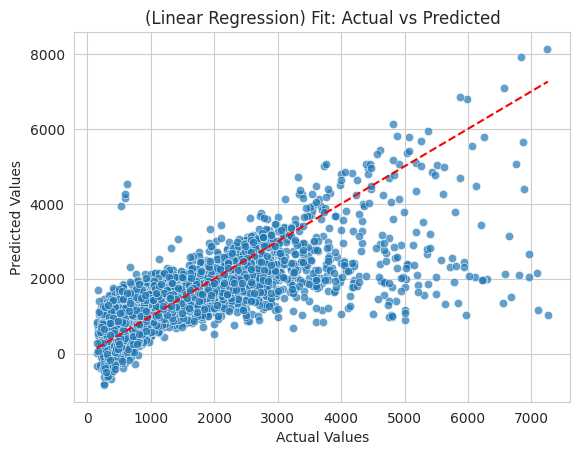

In [90]:
x_ = np.array(y_test['price'])
y_ = lin_reg.predict(X_test).flatten()
#plt.subplot(1,2,2)
sns.scatterplot(x=x_, y=y_, alpha=0.7)
plt.plot([min(y_test['price']), max(y_test['price'])], [min(y_test['price']), max(y_test['price'])], color='red', linestyle='--')  # Perfect fit line
plt.title("(Linear Regression) Fit: Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

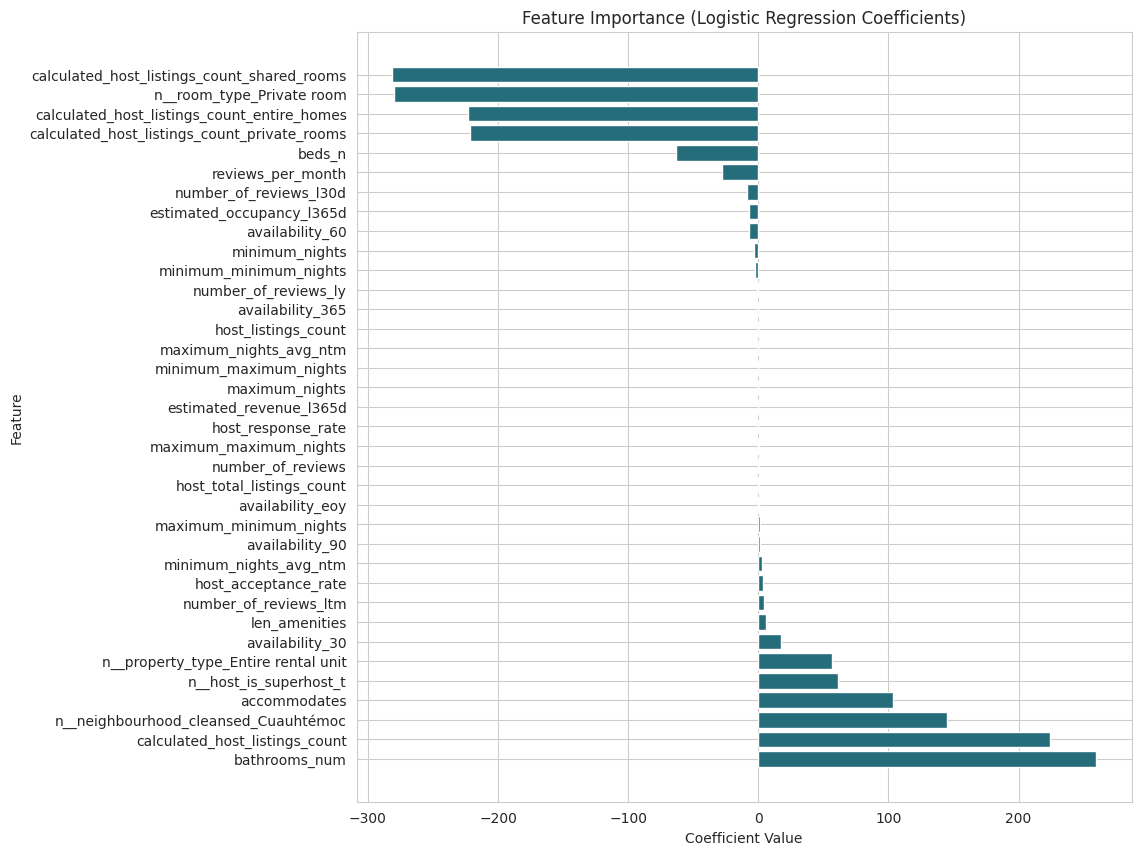

In [91]:
# Extraer información del modelo
#print("Intercept:", model.intercept_)
coeff_df = pd.DataFrame({"Feature": X_train.columns, "Coefficient": lin_reg.coef_[0]})
#print("\nFeature Coefficients:\n", coeff_df)

# Resumir los resultados del modelo
# Sort dataframe by coefficients.
coef_df_sorted = coeff_df.sort_values(by="Coefficient", ascending=False)

# Create plot.
plt.figure(figsize=(10,10))
#plt.barh(coeff_df["Feature"], coef_df_sorted["Coefficient"], color="blue")
plt.barh(data=coef_df_sorted, y="Feature", width="Coefficient", color="#256D7B")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.show()

##### Lars regression

In [92]:
# Lars regression
from sklearn.linear_model import Lars

# fit model
lars_reg = Lars()
lars_reg.fit(X_train, y_train)

# model evaluation
ls_scores = cross_val_score(estimator=lars_reg, X=X_train, y=y_train, cv=4, n_jobs=-1, scoring="r2")
print("MEAN", ls_scores.mean())
print("STD", ls_scores.std())

# Make predictions.
y_pred = lars_reg.predict(X_test[X_train.columns])
# Calculate and print errors.
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse:.4f}")
rmse = mse ** 0.5
print(f"Root mean squared error: {rmse:.4f}")
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
print(f"Mean Absolute Error: {mae:.4f}")

MEAN -1.994140705617597
STD 1.9773273466596988
R-squared: -3.0731
Mean squared error: 4366000.4899
Root mean squared error: 2089.4977
Mean Absolute Error: 623.0451


Text(0, 0.5, 'Predicted Values')

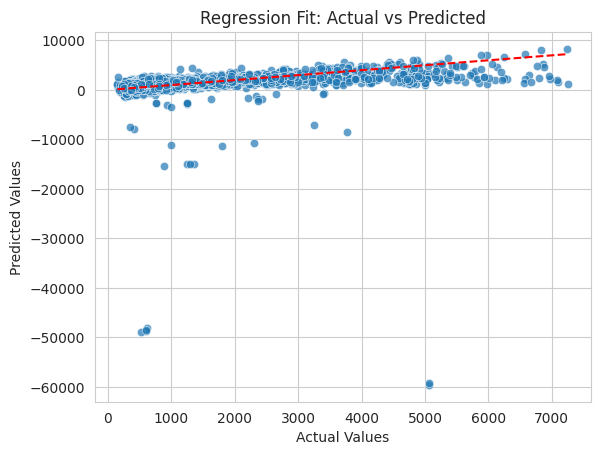

In [93]:
x_ = np.array(y_test['price'])
y_ = lars_reg.predict(X_test).flatten()
#plt.subplot(1,2,2)
sns.scatterplot(x=x_, y=y_, alpha=0.7)
plt.plot([min(y_test['price']), max(y_test['price'])], [min(y_test['price']), max(y_test['price'])], color='red', linestyle='--')  # Perfect fit line
plt.title("Regression Fit: Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

##### Ridge regression

In [94]:
# Ridge regression
from sklearn.linear_model import Ridge

# fit model
ridge_reg = Ridge(tol=1e-07, solver='svd', alpha=0.5)
ridge_reg.fit(X_train, y_train)

# model evaluation
ls_scores = cross_val_score(estimator=ridge_reg, X=X_train, y=y_train, cv=4, n_jobs=-1, scoring="r2")
print("MEAN", ls_scores.mean())
print("STD", ls_scores.std())

# Make predictions.
y_pred = ridge_reg.predict(X_test[X_train.columns])
# Calculate and print errors.
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse:.4f}")
rmse = mse ** 0.5
print(f"Root mean squared error: {rmse:.4f}")
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
print(f"Mean Absolute Error: {mae:.4f}")

MEAN 0.594086242899269
STD 0.026031956597912277
R-squared: 0.5777
Mean squared error: 452714.7570
Root mean squared error: 672.8408
Mean Absolute Error: 427.7237


Text(0, 0.5, 'Predicted Values')

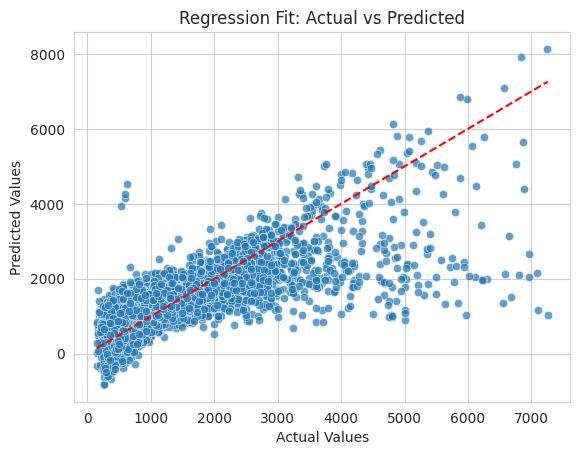

In [95]:
x_ = np.array(y_test['price'])
y_ = ridge_reg.predict(X_test).flatten()
#plt.subplot(1,2,2)
sns.scatterplot(x=x_, y=y_, alpha=0.7)
plt.plot([min(y_test['price']), max(y_test['price'])], [min(y_test['price']), max(y_test['price'])], color='red', linestyle='--')  # Perfect fit line
plt.title("Regression Fit: Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

In [96]:
# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# params
param_grid = {
    "alpha": [x for x in range(1, 100)] + [y/10 for y in range(10)],
    "tol": [0.00001, 0.0000001, 0.01],
    "solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

clf = RandomizedSearchCV(
    n_iter=500,
    estimator=ridge_reg,
    param_distributions=param_grid,
    cv=3,
    error_score=-1000,
    n_jobs=-1,
    scoring="r2",
    verbose=5
)

clf.fit(X_train, y_train)

print("best_score_    :", clf.best_score_)
print("best_params_   :", clf.best_params_)
print("best_estimator_:", clf.best_estimator_)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
best_score_    : 0.5965515316853426
best_params_   : {'tol': 0.01, 'solver': 'cholesky', 'alpha': 12}
best_estimator_: Ridge(alpha=12, solver='cholesky', tol=0.01)


Este modelo resulto como el mejor de acuerdo a la metrica de "R2", es el modelo seleccionado. Los parametros se seleccionaron con RandomSearchCV.

In [153]:
# Ridge regression
from sklearn.linear_model import Ridge

# fit model
ridge_reg = Ridge(tol=0.01, solver='cholesky', alpha=12)
ridge_reg.fit(X_train, y_train)

# model evaluation
ls_scores = cross_val_score(estimator=ridge_reg, X=X_train, y=y_train, cv=4, n_jobs=-1, scoring="r2")
print("MEAN", ls_scores.mean())
print("STD", ls_scores.std())

# Make predictions.
y_pred = ridge_reg.predict(X_test[X_train.columns])
# Calculate and print errors.
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse:.4f}")
rmse = mse ** 0.5
print(f"Root mean squared error: {rmse:.4f}")
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
print(f"Mean Absolute Error: {mae:.4f}")

MEAN 0.585912624702639
STD 0.010273362782213784
R-squared: 0.6130
Mean squared error: 396394.0966
Root mean squared error: 629.5984
Mean Absolute Error: 414.1256


Text(0, 0.5, 'Predicted Values')

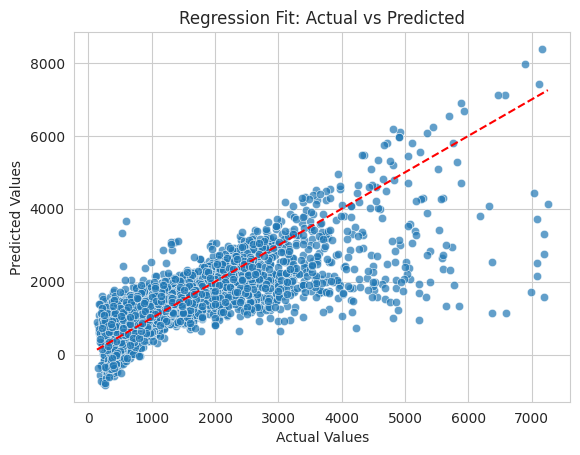

In [155]:
x_ = np.array(y_test['price'])
y_ = ridge_reg.predict(X_test).flatten()
#plt.subplot(1,2,2)
sns.scatterplot(x=x_, y=y_, alpha=0.7)
plt.plot([min(y_test['price']), max(y_test['price'])], [min(y_test['price']), max(y_test['price'])], color='red', linestyle='--')  # Perfect fit line
plt.title("Regression Fit: Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

In [160]:
# Extraer información del modelo
#print("Intercept:", model.intercept_)
coeff_df = pd.DataFrame({"Feature": X_train.columns, "Coefficient": ridge_reg.coef_})
print("\nFeature Coefficients:\n", coeff_df)


Feature Coefficients:
                                          Feature  Coefficient
0                             host_response_rate         0.27
1                           host_acceptance_rate         3.48
2                            host_listings_count        -0.41
3                      host_total_listings_count         0.38
4                                   accommodates       106.76
5                                         beds_n       -61.90
6                                 minimum_nights        -3.86
7                                 maximum_nights        -0.05
8                         minimum_minimum_nights        -0.84
9                         maximum_minimum_nights         2.90
10                        minimum_maximum_nights        -0.13
11                        maximum_maximum_nights         0.22
12                        minimum_nights_avg_ntm        -0.11
13                        maximum_nights_avg_ntm        -0.17
14                               availability_

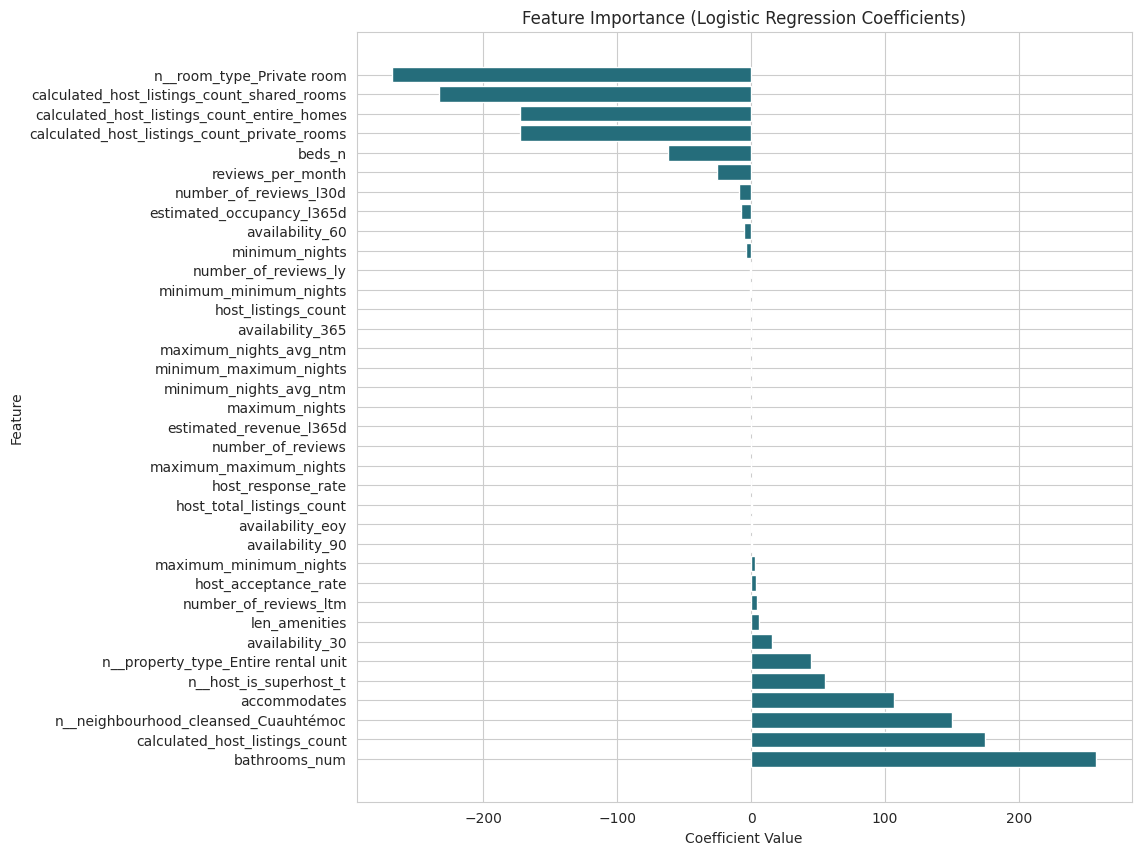

In [162]:
# Extraer información del modelo
#print("Intercept:", model.intercept_)
coeff_df = pd.DataFrame({"Feature": X_train.columns, "Coefficient": ridge_reg.coef_})
#print("\nFeature Coefficients:\n", coeff_df)

# Resumir los resultados del modelo
# Sort dataframe by coefficients.
coef_df_sorted = coeff_df.sort_values(by="Coefficient", ascending=False)

# Create plot.
plt.figure(figsize=(10,10))
#plt.barh(coeff_df["Feature"], coef_df_sorted["Coefficient"], color="blue")
plt.barh(data=coef_df_sorted, y="Feature", width="Coefficient", color="#256D7B")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.show()

##### ElasticNet regression

In [98]:
# ElasticNet regression
from sklearn.linear_model import ElasticNet

elastic_reg = ElasticNet()
elastic_reg.fit(X_train, y_train)

ls_scores = cross_val_score(estimator=elastic_reg, X=X_train, y=y_train, cv=4, n_jobs=-1, scoring="r2")
print("MEAN", ls_scores.mean())
print("STD", ls_scores.std())

# Make predictions.
y_pred = elastic_reg.predict(X_test[X_train.columns])
# Calculate and print errors.
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse:.4f}")
rmse = mse ** 0.5
print(f"Root mean squared error: {rmse:.4f}")
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
print(f"Mean Absolute Error: {mae:.4f}")

MEAN 0.5744470546380478
STD 0.018771583475941468
R-squared: 0.5666
Mean squared error: 464594.6163
Root mean squared error: 681.6118
Mean Absolute Error: 437.1759


In [ ]:
"""# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# params
param_grid = {
    "alpha": [x for x in range(1, 100)] + [y/10 for y in range(10)],
    "l1_ratio": [x for x in range(1, 100)] + [y/10 for y in range(10)],
    "selection": ["cyclic", "random"]
}

clf = RandomizedSearchCV(
    n_iter=20,
    estimator=elastic_reg,
    param_distributions=param_grid,
    cv=4,
    error_score=-1000,
    n_jobs=-1,
    scoring="r2",
    verbose=5
)

clf.fit(X_train, y_train)

print("best_score_    :", clf.best_score_)
print("best_params_   :", clf.best_params_)
print("best_estimator_:", clf.best_estimator_)"""

##### Lasso regression

In [100]:
# Lasso regression
from sklearn.linear_model import Lasso

# fit model
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

# model evalation
ls_scores = cross_val_score(estimator=lasso_reg, X=X_train, y=y_train, cv=4, n_jobs=-1, scoring="r2")
print("MEAN", ls_scores.mean())
print("STD", ls_scores.std())

# Make predictions.
y_pred = lasso_reg.predict(X_test[X_train.columns])
# Calculate and print errors.
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse:.4f}")
rmse = mse ** 0.5
print(f"Root mean squared error: {rmse:.4f}")
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
print(f"Mean Absolute Error: {mae:.4f}")

MEAN 0.5908021089053908
STD 0.01858258852163987
R-squared: 0.5844
Mean squared error: 445492.1686
Root mean squared error: 667.4520
Mean Absolute Error: 427.2678


In [101]:
# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# params
param_grid = {
    "alpha": [x for x in range(1, 100)] + [y/10 for y in range(10)],
    "tol": [0.00001, 0.0000001, 0.01],
    "selection": ['cyclic', 'random']
}

clf = RandomizedSearchCV(
    n_iter=100,
    estimator=lasso_reg,
    param_distributions=param_grid,
    cv=3,
    error_score=-1000,
    n_jobs=-1,
    scoring="r2",
    verbose=5
)

clf.fit(X_train, y_train)

print("best_score_    :", clf.best_score_)
print("best_params_   :", clf.best_params_)
print("best_estimator_:", clf.best_estimator_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
best_score_    : 0.5913509704939808
best_params_   : {'tol': 1e-05, 'selection': 'cyclic', 'alpha': 0.2}
best_estimator_: Lasso(alpha=0.2, tol=1e-05)


##### SDGRegressor

In [102]:
from sklearn.linear_model import SGDRegressor

# fit model
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train, y_train)

# model evalation
ls_scores = cross_val_score(estimator=sgd_reg, X=X, y=y, cv=4, n_jobs=-1, scoring="r2")
print("MEAN", ls_scores.mean())
print("STD", ls_scores.std())

# Make predictions.
y_pred = sgd_reg.predict(X_test[X_train.columns])
# Calculate and print errors.
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse:.4f}")
rmse = mse ** 0.5
print(f"Root mean squared error: {rmse:.4f}")
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
print(f"Mean Absolute Error: {mae:.4f}")


MEAN -9.831211224022735e+31
STD 4.931105464890832e+31
R-squared: -300835782977479061047796039680.0000
Mean squared error: 322467186616818390837558595618340864.0000
Root mean squared error: 567861943272146368.0000
Mean Absolute Error: 328975512931435648.0000


In [103]:
# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# params
param_grid = {
    "loss": ["squared_loss", "huber"],
    "penalty": ["l2", "l1", "elasticnet"],
    "alpha": [x/100+0.01 for x in range(100)],
    "epsilon": [x/10 for x in range(10)],
    "learning_rate": ["constant", "optimal", "invscaling", "adaptive"],
}

clf = RandomizedSearchCV(
    n_iter=10,
    estimator=sgd_reg,
    param_distributions=param_grid,
    cv=4,
    error_score=-1000,
    n_jobs=-1,
    scoring="r2",
    verbose=5
)

clf.fit(X_train, y_train)

print("best_score_    :", clf.best_score_)
print("best_params_   :", clf.best_params_)
print("best_estimator_:", clf.best_estimator_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
best_score_    : -48.0808347928683
best_params_   : {'penalty': 'l2', 'loss': 'huber', 'learning_rate': 'adaptive', 'epsilon': 0.4, 'alpha': 0.73}
best_estimator_: SGDRegressor(alpha=0.73, epsilon=0.4, learning_rate='adaptive', loss='huber')


##### Decision Tree Regressor

In [104]:
from sklearn.tree import DecisionTreeRegressor


# fit model
sgd_reg = DecisionTreeClassifier()
sgd_reg.fit(X_train, y_train)

# model evalation
ls_scores = cross_val_score(estimator=sgd_reg, X=X, y=y, cv=4, n_jobs=-1, scoring="r2")
print("MEAN", ls_scores.mean())
print("STD", ls_scores.std())

# Make predictions.
y_pred = sgd_reg.predict(X_test[X_train.columns])
# Calculate and print errors.
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse:.4f}")
rmse = mse ** 0.5
print(f"Root mean squared error: {rmse:.4f}")
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
print(f"Mean Absolute Error: {mae:.4f}")


MEAN 0.19324429581208383
STD 0.15111626927228827
R-squared: 0.1578
Mean squared error: 902704.5747
Root mean squared error: 950.1077
Mean Absolute Error: 519.6450


#### Clasificacion

##### Mejores variables

In [105]:
var_obj_cat = ['availability_cat']

In [106]:
# Preparacion de sets
X = listings.drop( columns=var_disc)[var_cont].join(pd.get_dummies(listings[var_disc], drop_first=True))
y = listings[var_obj_cat].replace({'LOW':0, 'HIGH':1})

In [107]:
# eliminamos columnas de disponibilidad
cols = [x for x in X.columns if x not in ['availability_30', 'availability_60', 'availability_90', 'availability_365', 'availability_eoy']]

In [108]:
X = X[cols]

In [109]:
print(X.shape)
print(y.shape)

(21124, 56)
(21124, 1)


In [ ]:
"""from sklearn.feature_selection import SelectKBest, f_regression, f_classif

kb = SelectKBest( k=40, score_func=f_classif )
kb.fit(X, y)

ls_best = [x for x, y in zip(X.columns, kb.get_support()) if y]
print(ls_best)

X = pd.DataFrame(kb.transform(X), columns=ls_best)
display(X)"""

##### Conjutno de entrenamiento y validación

In [110]:
# training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y)

##### Regresión logistica

In [111]:
log_reg = LogisticRegression()

In [112]:
log_reg.fit(X_train, y_train)

LogisticRegression()

In [113]:
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

print("\nClassification Report Mejorado:")
print(classification_report(y_test, y_pred))


Classification Report Mejorado:
              precision    recall  f1-score   support

           0       0.64      0.69      0.67      2905
           1       0.58      0.53      0.56      2376

    accuracy                           0.62      5281
   macro avg       0.61      0.61      0.61      5281
weighted avg       0.62      0.62      0.62      5281



In [114]:
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.2f}")

AUC-ROC: 0.66


In [115]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': log_reg.coef_[0]
}).sort_values('Importance', ascending=False)

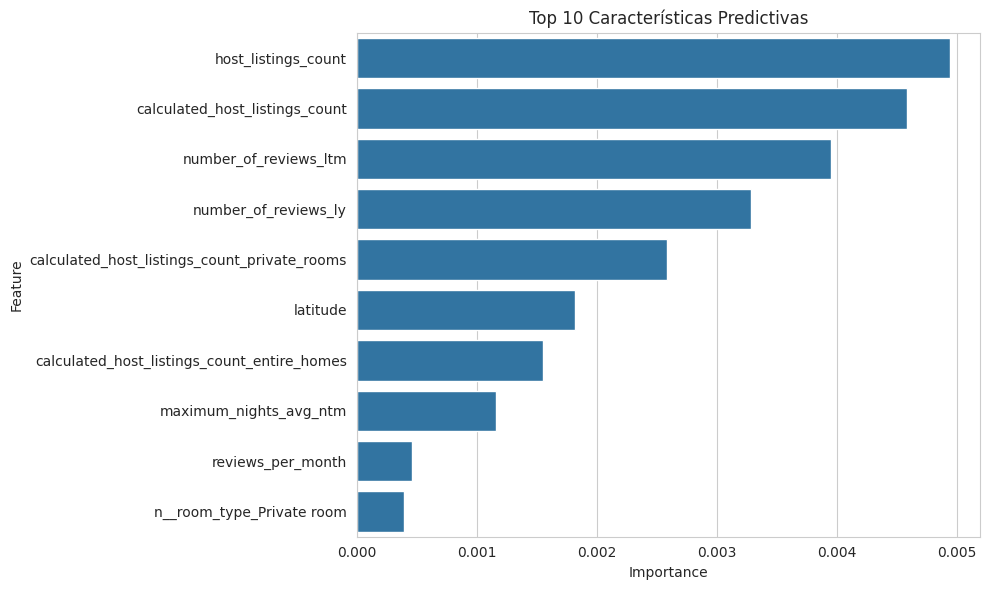

In [116]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Características Predictivas')
plt.tight_layout()
plt.show()

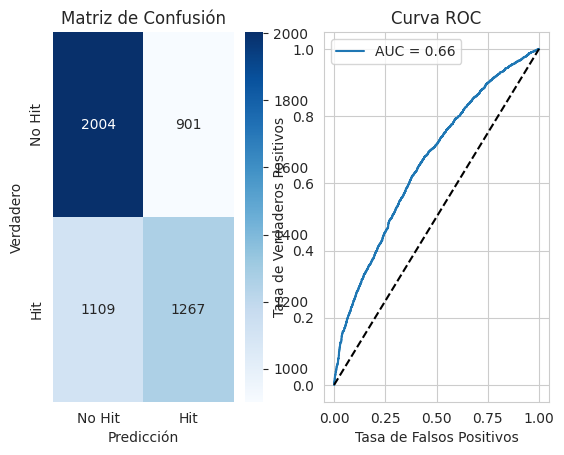

In [117]:
# Plot 1
plt.subplot(1,2,1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Hit', 'Hit'],
            yticklabels=['No Hit', 'Hit'])
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')

# Plot 2
plt.subplot(1,2,2)
fpr, tpr, thresholds = roc_curve(y_test.values, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()

plt.show()

##### Arboles de decision

In [118]:
tree_class = DecisionTreeClassifier()

In [119]:
# Fit the model
tree_class.fit(X_train, y_train)

DecisionTreeClassifier()

In [120]:
y_pred = tree_class.predict(X_test)
y_proba = tree_class.predict_proba(X_test)[:, 1]

print("\nClassification Report Mejorado:")
print(classification_report(y_test, y_pred))


Classification Report Mejorado:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      2905
           1       0.58      0.59      0.59      2376

    accuracy                           0.63      5281
   macro avg       0.62      0.62      0.62      5281
weighted avg       0.63      0.63      0.63      5281



In [121]:
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.2f}")

AUC-ROC: 0.62


In [122]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': tree_class.feature_importances_
}).sort_values('Importance', ascending=False)

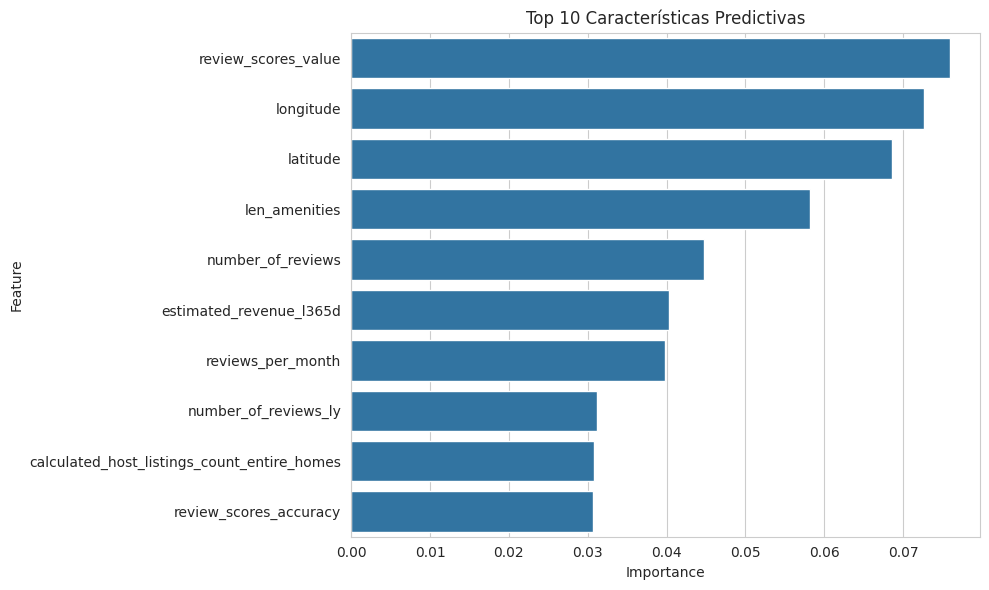

In [123]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Características Predictivas')
plt.tight_layout()
plt.show()

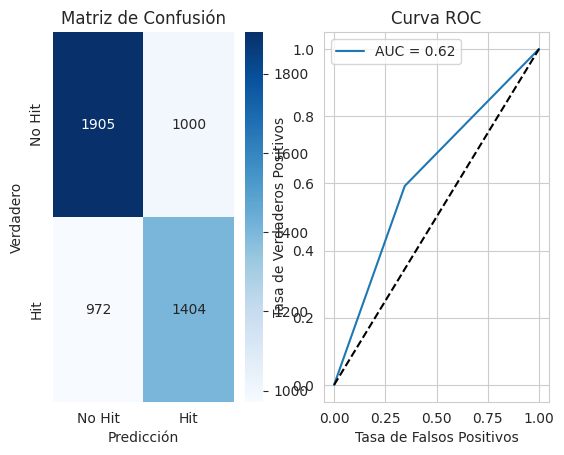

In [124]:
# Plot 1
plt.subplot(1,2,1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Hit', 'Hit'],
            yticklabels=['No Hit', 'Hit'])
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')

# Plot 2
plt.subplot(1,2,2)
fpr, tpr, thresholds = roc_curve(y_test.values, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()

plt.show()

##### RandomForestClassifier

In [125]:
rnd_forest = RandomForestClassifier(max_depth=4, max_features=4, min_samples_split=3, random_state=1) # Pass hyperparameters
rnd_forest = RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=3, random_state=1) # Pass hyperparameters

In [126]:
rnd_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=3,
                       random_state=1)

In [127]:
y_pred = rnd_forest.predict(X_test)
y_proba = rnd_forest.predict_proba(X_test)[:, 1]

print("\nClassification Report Mejorado:")
print(classification_report(y_test, y_pred))


Classification Report Mejorado:
              precision    recall  f1-score   support

           0       0.69      0.79      0.74      2905
           1       0.69      0.57      0.62      2376

    accuracy                           0.69      5281
   macro avg       0.69      0.68      0.68      5281
weighted avg       0.69      0.69      0.68      5281



In [128]:
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.2f}")

AUC-ROC: 0.76


In [129]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rnd_forest.feature_importances_
}).sort_values('Importance', ascending=False)

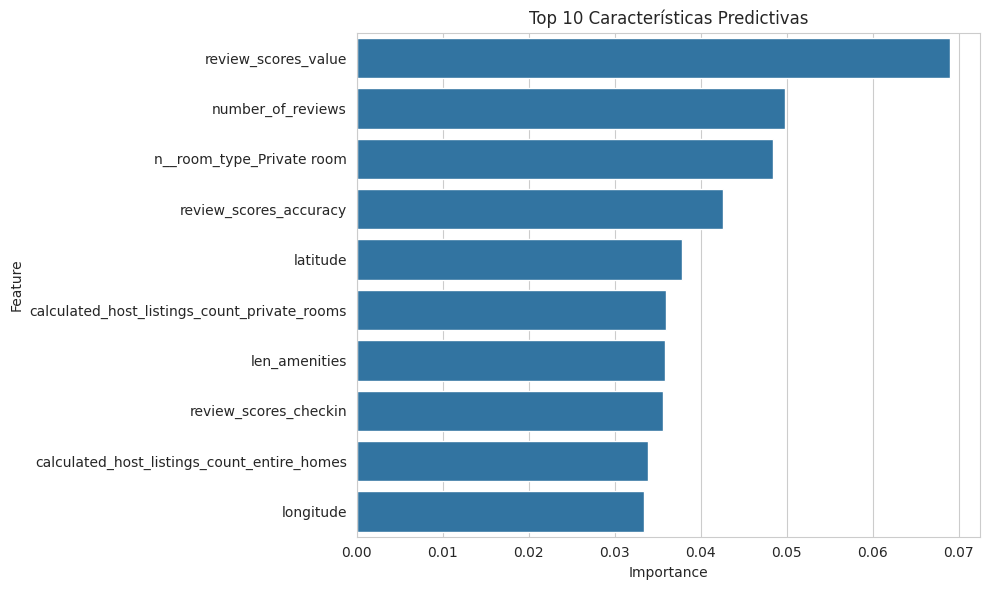

In [130]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Características Predictivas')
plt.tight_layout()
plt.show()

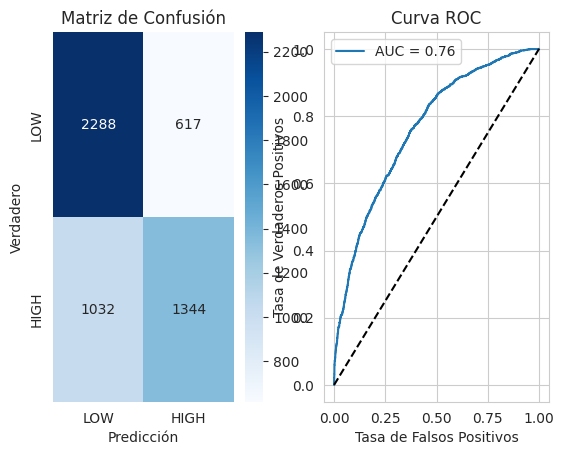

In [131]:
# Plot 1
plt.subplot(1,2,1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['LOW', 'HIGH'],
            yticklabels=['LOW', 'HIGH'])
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')

# Plot 2
plt.subplot(1,2,2)
fpr, tpr, thresholds = roc_curve(y_test.values, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()

plt.show()

##### XGBClassifier

In [132]:
xgb = XGBClassifier(learning_rate=0.1,
                    n_estimators=190,
                    max_depth=8,
                    min_child_weight=2,
                    objective="binary:logistic",
                    subsample=0.9,
                    colsample_bytree=0.8,
                    seed=23333)

In [133]:
xgb.fit(X_train, y_train.astype(int))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=190, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [134]:
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print("\nClassification Report Mejorado:")
print(classification_report(y_test, y_pred))


Classification Report Mejorado:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75      2905
           1       0.70      0.66      0.68      2376

    accuracy                           0.72      5281
   macro avg       0.72      0.72      0.72      5281
weighted avg       0.72      0.72      0.72      5281



In [135]:
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.2f}")

AUC-ROC: 0.80


In [136]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb.feature_importances_
}).sort_values('Importance', ascending=False)

In [165]:
feature_importance.head(10)

Feature  Importance
52                    n__room_type_Private room        0.13
45         n__neighbourhood_cleansed_Cuauhtémoc        0.05
29                          review_scores_value        0.04
7                                    bedrooms_n        0.04
9                                minimum_nights        0.02
15                       minimum_nights_avg_ntm        0.02
31  calculated_host_listings_count_entire_homes        0.02
33  calculated_host_listings_count_shared_rooms        0.02
43          n__neighbourhood_cleansed_CAT_PEQUE        0.02
38           n__host_response_time_sin_registro        0.02

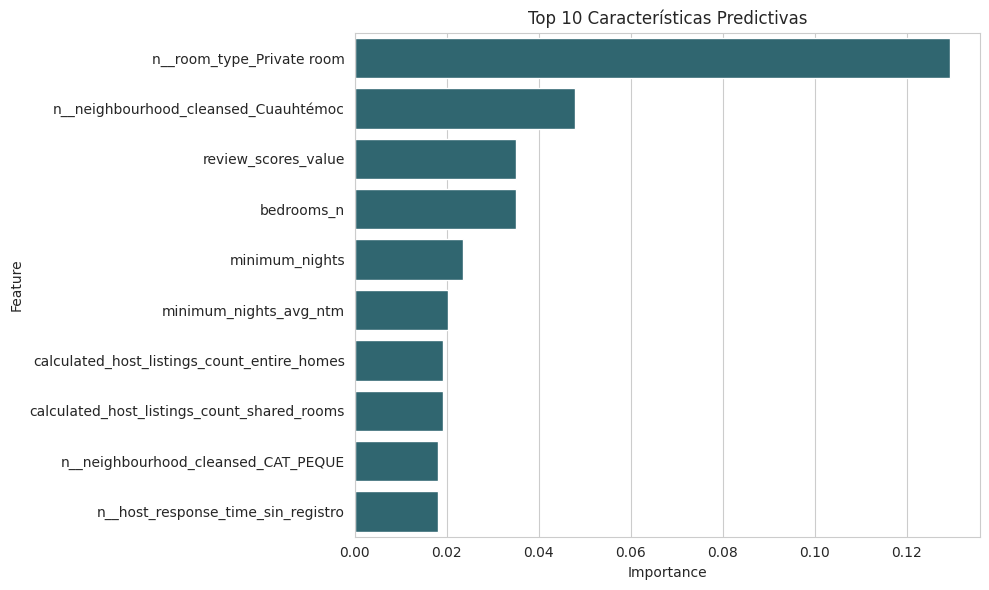

In [166]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10), color="#256D7B")
plt.title('Top 10 Características Predictivas')
plt.tight_layout()
plt.show()

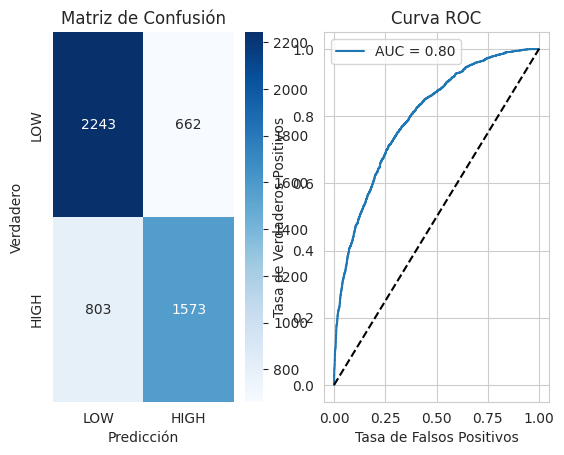

In [138]:
# Plot 1
plt.subplot(1,2,1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['LOW', 'HIGH'],
            yticklabels=['LOW', 'HIGH'])
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')

# Plot 2
plt.subplot(1,2,2)
fpr, tpr, thresholds = roc_curve(y_test.values, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()

plt.show()

##### Voting

In [139]:
naiveb = GaussianNB()
logreg = LogisticRegression()
dctree = DecisionTreeClassifier()

In [140]:
voting_clf = VotingClassifier(
    estimators=[('naiveb', naiveb), ('logreg', logreg), ('dctree', dctree)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('naiveb', GaussianNB()),
                             ('logreg', LogisticRegression()),
                             ('dctree', DecisionTreeClassifier())])

In [141]:
y_pred = voting_clf.predict(X_test)

print("\nClassification Report Mejorado:")
print(classification_report(y_test, y_pred))


Classification Report Mejorado:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68      2905
           1       0.60      0.52      0.56      2376

    accuracy                           0.63      5281
   macro avg       0.62      0.62      0.62      5281
weighted avg       0.62      0.63      0.62      5281

